# Read output files

In [1]:
import awkward as ak
import numpy as np
import os
import pandas as pd

In [48]:
basedir = {
    year: {
        r'Top+$\gamma$': [f'../condor/output/mc/{year}/{channel}/' for channel in ['TTGJets']],
        r'Z+$\gamma$': [f'../condor/output/mc/{year}/{channel}/' for channel in ['ZGToLLG', 'ZGToJJG']],
        r'W+$\gamma$': [f'../condor/output/mc/{year}/{channel}/' for channel in ['WGToJJG', 'WGToLNuG']],
        r'fake $\gamma$ events': [f'../condor/output/mc/{year}/{channel}/' for channel in ['ST', 'TTJets', 'ZJetsToNuNu', 'ZJetsToLL', 'ZJetsToQQ', 'WJetsToLNu', 'WJetsToQQ', 'QCD']],
        r'QCD+$\gamma$': [f'../condor/output/mc/{year}/{channel}/' for channel in ['GJets']],
        r'$Z^\mathrm{\prime}(1TeV)\to H\gamma$': [f'../condor/output/mc/{year}/ZpToHG/ZpToHGamma_M1000/'],
        r'$Z^\mathrm{\prime}(2TeV)\to H\gamma$': [f'../condor/output/mc/{year}/ZpToHG/ZpToHGamma_M2000/'],
        r'$Z^\mathrm{\prime}(3TeV)\to H\gamma$': [f'../condor/output/mc/{year}/ZpToHG/ZpToHGamma_M3000/'],
        'data': [f'../condor/output/data/{year}/' + ('SinglePhoton' if year!='2018' else 'EGamma')],
    } for year in ['2016pre', '2016post', '2017', '2018']
}

BKG = set([k for k in basedir['2018'].keys() if not (r'H\gamma' in k or k=='data')])
SIG_COLOR = {
    r'$Z^\mathrm{\prime}(1TeV)\to H(bb)\gamma$': 'red',
    r'$Z^\mathrm{\prime}(2TeV)\to H(bb)\gamma$': 'blue',
    r'$Z^\mathrm{\prime}(3TeV)\to H(bb)\gamma$': 'gold',
}

filepath={year: {c: [] for c in basedir[year]} for year in basedir}
for year, paths in basedir.items():
    for mc, folders in paths.items():
        for folder in folders:
            for (current_path, dirs, files) in os.walk(folder):
                for f in files:
                    if f.endswith('.parq'):
                        filepath[year][mc].append(os.path.join(current_path, f))

In [49]:
events = {year: {k: [] for k in filepath[year]} for year in filepath}
for year in filepath:
    for k, v in filepath[year].items():
        for f in v:
            if os.path.getsize(f) == 0 or len(ak.from_parquet(f))==0:
                continue
            array = ak.from_parquet(f)
            if len(array)>0:
                events[year][k].append(array)
        if len(events[year][k]) > 0:
            events[year][k] = ak.concatenate(events[year][k], axis=0)

weight={y: {c: events[y][c].event_final_weight for c in events[y] if c!='data' and len(events[y][c])>0} for y in events}

In [4]:
events['2018'][r'W+$\gamma$'].event_genWeight, events['2018'][r'W+$\gamma$'].event_final_weight

(<Array [1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, -1, 1, -1] type='83798 * ?float32'>,
 <Array [2.38, 2.21, 2.28, ..., -0.127, 0.146, -0.119] type='83798 * float64'>)

# Decomposite signal

In [14]:
def decomposite(signal: ak.Array):
    HWW_decay_mode = ak.fill_none(signal['gen_HWW_decay_mode'], 0)
    
    signal['HWW_4q'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode >= 32)
    
    signal['HWW_qqlv'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode > 16) & (HWW_decay_mode < 32)
    
    signal['HWW_lvlv'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode <= 16)
    
    return signal

DECOMPOSITE = True
if DECOMPOSITE:
    for y, event in events.items():
        for c in list(event.keys()):
            if r'H\gamma' not in c:
                continue
            events[y].update({c: decomposite(events[y][c])})
            events[y][c.replace(r'H\gamma', r'H(WW)\gamma')] = events[y][c][events[y][c]['gen_ZpToH(WW)Gamma']]
            events[y][c.replace(r'H\gamma', r'H(bb)\gamma')] = events[y][c][events[y][c]['gen_ZpToH(bb)Gamma']]
            weight[y][c.replace(r'H\gamma', r'H(WW)\gamma')] = weight[y][c][events[y][c]['gen_ZpToH(WW)Gamma']]
            weight[y][c.replace(r'H\gamma', r'H(bb)\gamma')] = weight[y][c][events[y][c]['gen_ZpToH(bb)Gamma']]

events

{'2016pre': {'Top+$\\gamma$': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='1312 * {AK8jet_rankTo...'>,
  'Z+$\\gamma$': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='36063 * {AK8jet_rankT...'>,
  'W+$\\gamma$': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='67280 * {AK8jet_rankT...'>,
  'fake $\\gamma$ events': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='2425 * {AK8jet_rankTo...'>,
  'QCD+$\\gamma$': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='119185 * {AK8jet_rank...'>,
  '$Z^\\mathrm{\\prime}(1TeV)\\to H\\gamma$': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='31117 * {AK8jet_rankT...'>,
  '$Z^\\mathrm{\\prime}(2TeV)\\to H\\gamma$': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='41284 * {AK8jet_rankT...'>,
  '$Z^\\mathrm{\\prime}(3TeV)\\to H\\gamma$': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='42518 * {AK8jet_rankT...'>,
  'data': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='121100 * {AK8jet_rank...'>,
  '$

# Start plotting

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return np.abs(h), var

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    return np.array([down_error_bar, up_error_bar])

## Data comparison

In [7]:
def data_compare_plot(arrays, plot_name: str, x_name: str, cuts=None, bins=40, x_min=0, x_max=3000, density=True, overflow=True, underflow=False):
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}

    ## canvas initializing
    # colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=True, ax=ax, fontsize=18)
    
    ## analyze

        
    ## plot
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=['red', 'blue', 'green', 'darkorange', 'cyan', 'HotPink', 'darkviolet', 'SlateGray', 'black', 'LightSkyBlue'])
    for (k, v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(v)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        hep.histplot(h, bins=hist.axes[0].edges, xerr=bin_width/2, yerr=error_bar(h, var, type='data'), label=k, histtype='step', density=density, stack=False, ax=ax, linewidth=2)
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too) 

    ## axises
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_xlim(x_min, x_max)
    if 'eta' in plot_name:
        ax.set_ylim(1e-2, ax.get_ylim()[1]*5)
    else:
        ax.set_ylim(1e-8, ax.get_ylim()[1]*5)
    ax.set_yscale('log')
    #ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    #x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    #y_major_locator=MultipleLocator(1)
    #ax.xaxis.set_major_locator(x_major_locator)
    #ax.yaxis.set_major_locator(y_major_locator)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=2, frameon=False, fontsize=18)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/data_compare_{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
arrays={k: events[k]['data'].photon_pt for k in events}
data_compare_plot(arrays, 'photon_pt', x_name=r'$p_T^{\gamma}$')

arrays={k: events[k]['data'].photon_eta for k in events}
data_compare_plot(arrays, 'photon_eta', x_name=r'$\eta_{\gamma}$', x_min=-3, x_max=3)

arrays={k: events[k]['data'].photon_phi for k in events}
data_compare_plot(arrays, 'photon_phi', x_name=r'$\phi_\gamma$', x_min=-4, x_max=4)

arrays={k: events[k]['data'].AK8jet_pt for k in events}
data_compare_plot(arrays, 'AK8jet_pt', x_name=r'$p_T^j$')

arrays={k: events[k]['data'].AK8jet_eta for k in events}
data_compare_plot(arrays, 'AK8jet_eta', x_name=r'$\eta_j$', x_min=-3, x_max=3)

arrays={k: events[k]['data'].AK8jet_phi for k in events}
data_compare_plot(arrays, 'AK8jet_phi', x_name=r'$\phi_j$', x_min=-4, x_max=4)

arrays={k: events[k]['data'].AK8jet_msoftdrop for k in events}
data_compare_plot(arrays, 'AK8jet_msoftdrop', x_name=r'$m_{SD}^j$', x_min=0, x_max=300)

AttributeError: 'list' object has no attribute 'photon_pt'

## Data-MC comparison

In [37]:
from matplotlib.cm import get_cmap

hep.style.use("CMS")
#mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab20").colors)
#print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

def data_mc_compare_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, fraction_log=False, mass_window=False):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax, ax1, ax2 = f.add_subplot(gs[0]), f.add_subplot(gs[1]), f.add_subplot(gs[2])
    ax.grid(); ax1.grid(); ax2.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
    
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        if 'delta_phi' in plot_name:
            values = np.min([v, 2*np.pi-v], axis=0)
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var
        
    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=density, stack=True, linewidth=2, ax=ax)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        # we usually don't care error of background MC cuz the stats is very large (relative error is very small compared with signal and data)
    for (k,h) in individual['h'].items():
        if k=='data':
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
        elif k in SIG_COLOR:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            if mass_window:
                mass_center = float(k.split('(')[1][:1])*1e3
                mass_std = ak.std(arrays[k], weight=weight[k])
                ax.arrow(x=mass_center - 2*mass_std, y=np.max(h)/10, dx=0, dy=1e-3-np.max(h)/10, length_includes_head=True, color='black', linewidth=2, linestyle='dashed')
                ax.arrow(x=mass_center + 2*mass_std, y=np.max(h)/10, dx=0, dy=1e-3-np.max(h)/10, length_includes_head=True, color='black', linewidth=2, linestyle='dashed')


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-3 if not density else 0, ax.get_ylim()[1]*(1e2 if not density else 1.2))
    if not density:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    
    #ax2.set_yscale('log')
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/{year}_{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()

W+$\gamma$ [9.56449110e+02 8.31257392e+00 3.14379554e-02 0.00000000e+00]


/tmp/ipykernel_3317930/4087906678.py:57: RuntimeWarning: divide by zero encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/home/dfu/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3648: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_

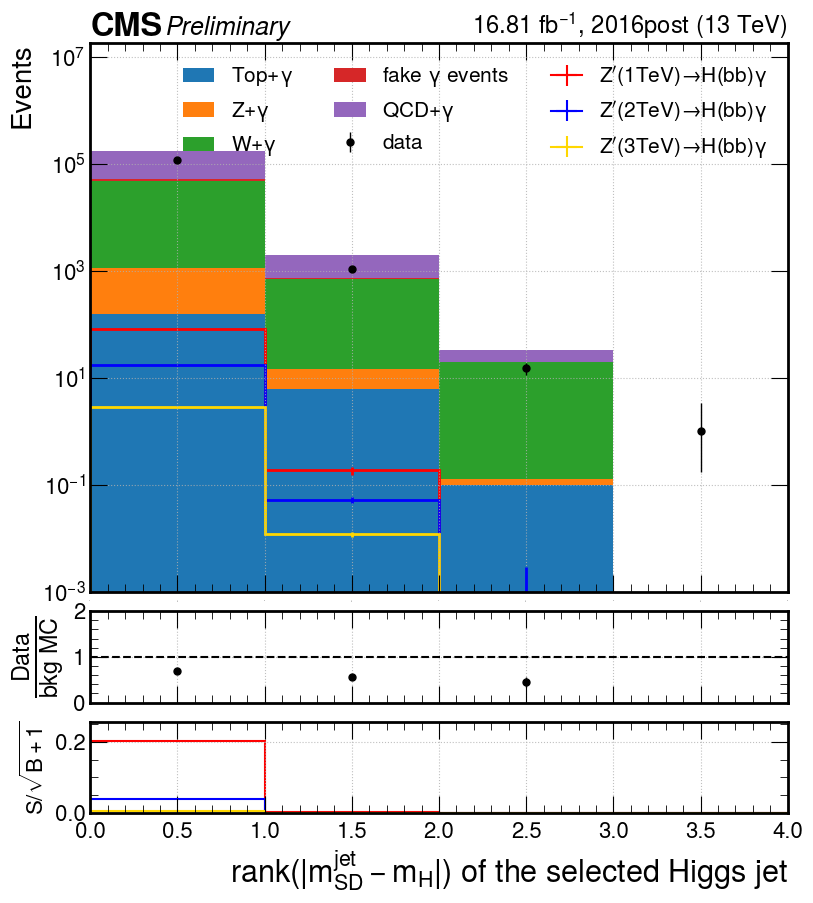

W+$\gamma$ [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.54252567e+01 1.69912074e+02
 1.73530422e+02 1.42634730e+02 1.15264837e+02 8.17551413e+01
 5.93364281e+01 4.41780716e+01 3.20017780e+01 2.45693732e+01
 1.53695448e+01 1.47029172e+01 8.77403910e+00 7.37349290e+00
 7.61653264e+00 5.38804859e+00 3.04000765e+00 2.37463593e+00
 1.05394367e+00 1.76516637e+00 1.12402274e+00 2.05497553e+00
 1.22281059e+00 6.38111989e-01 1.98616262e-01 3.69647550e-01
 3.70711789e-01 7.07091146e-01 2.94920207e-01 2.23672686e-01
 4.09404778e-01 3.51005638e-01 3.99994082e-01 4.64272259e-02
 5.15272116e-02 1.56356342e-01 1.79746307e-02 3.69574863e-03
 1.31221568e-01 4.76709691e-02 1.35662298e-02 7.53518503e-02
 7.36257300e-02 1.30553393e-01 0.00000000e+00 9.50388885e-02
 0.00000000e+00 0.00000000e+00 1.42328690e-01 0.00000000e+00
 5.07311179e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.94308541e-02 5.28664814e-02 0.00000000e+00 7.20312113e-03
 0.00000000e+

/tmp/ipykernel_3317930/4087906678.py:57: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid v

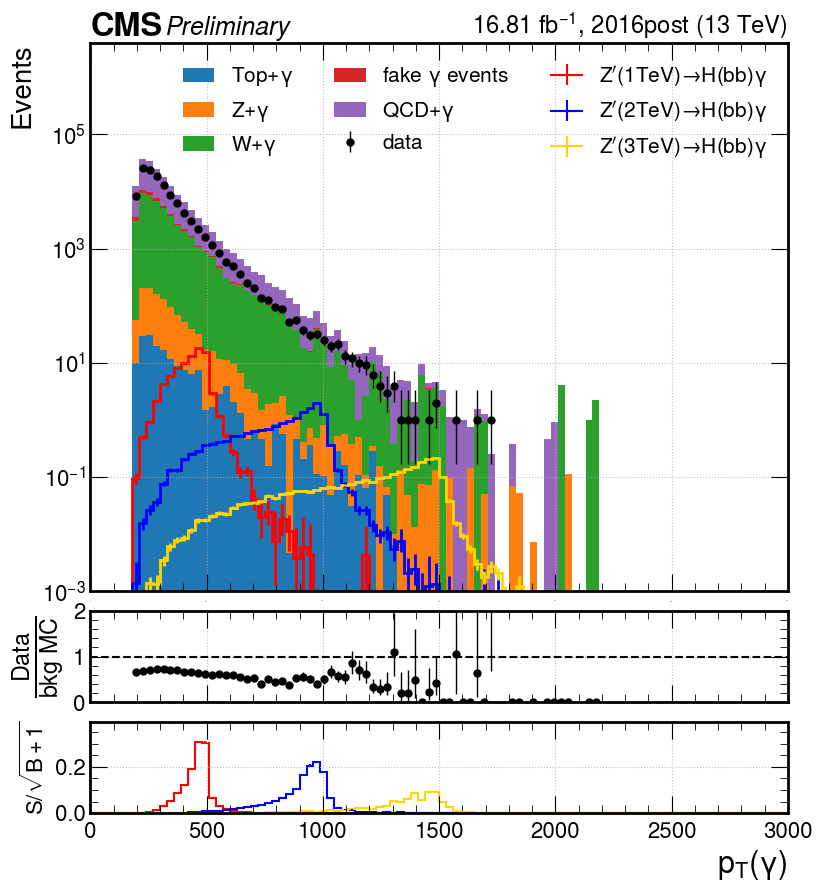

W+$\gamma$ [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  3.39711141  2.71279287  2.65416201  3.59668329  3.79099211  4.32857722
  3.86770085  3.45085517  5.35694756  6.05333418  6.63662537  9.42190806
  7.43098499  7.43254974  8.2215306   8.76677157  4.1385458   0.
  0.          8.9391564   9.33045841 10.25300994 11.15506137 13.43362316
 12.76326272 13.64522415 11.59315233 14.01694928 11.89841978 13.86362371
 15.38049313 13.41283293 11.98525076 13.41464099 13.98463903 15.0167217
 15.4164943  17.10676835 14.1809983  12.05184247 15.17507083 13.26541982
 13.91465449 15.83534167 14.15597585 15.6229569  15.8269393  14.512121
 14.97122544 14.34273597 12.99988815 16.32226651 17.78543239 15.9697133
 17.14269795 13.10196989 14.0743248  13.00843511 14.59118218 14.01946026
 15.70703685 13.04511415 14.49722587 13.12832751 13.06338177 17.4676679
 13.13703407 11.44454587 15.83234573 14.27543859  9.59240977 10.11035

/tmp/ipykernel_3317930/4087906678.py:57: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid v

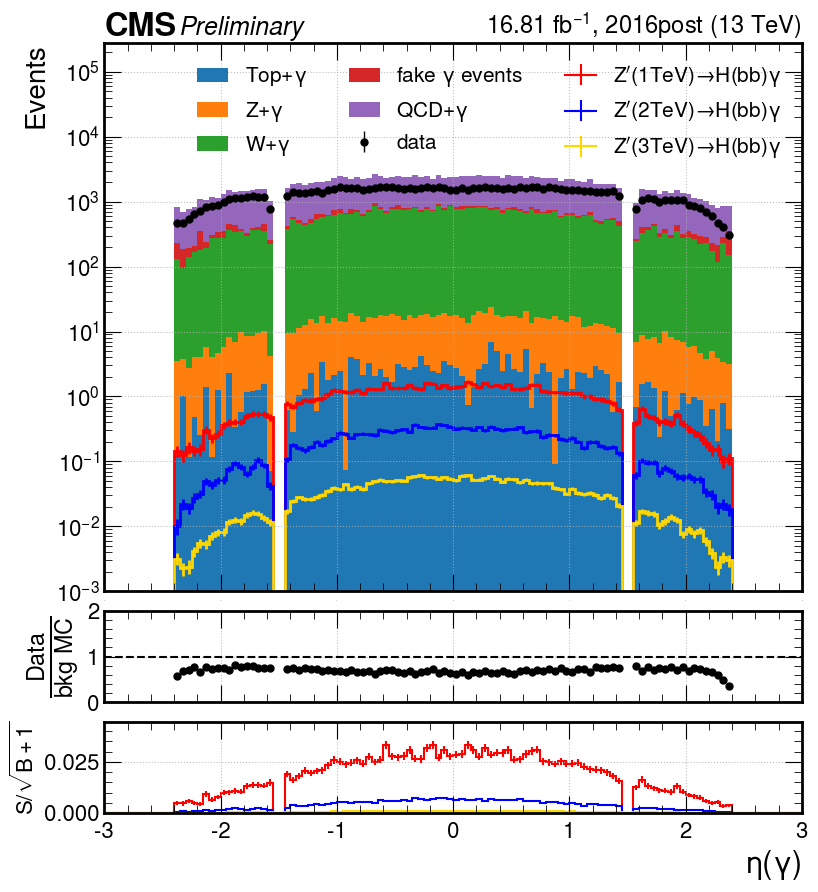

W+$\gamma$ [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  2.15787678 10.02252709  9.10045525  8.61585093  9.83831155  9.74347137
  9.76805436  9.38790926  9.58223081 11.03141538  9.10217261 11.23338522
 10.46059075 10.89084819  9.90006655 12.2693499  10.78835804  9.53280945
 10.17636062 10.19179126 10.34452867 10.70564555 11.08372148 11.73398587
  7.72960984 10.09406517  9.26077     8.76664601 11.36458562 10.1558317
  8.94016839 10.08211898  8.31119947  9.24931256 10.31992697 11.01910666
  9.87634844  9.27510641  7.56758746 12.06036542 12.21338784 12.44653498
 10.64832547 11.47402132  9.94092464 10.1547602   8.24526254  9.10040829
 12.24709224 10.47736417 10.37933062 10.51080626 12.49803042 11.08459355
 10.77842194 10.15438692 12.11023757 12.19124981 10.21424666 12.57549103
 11.1925027   8.32983542  9.31385966 10.62453357  9.20545472 10.3738814
 10.25693749 10.33040193 10.89830873 10.88092055 10.677879

/tmp/ipykernel_3317930/4087906678.py:57: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid v

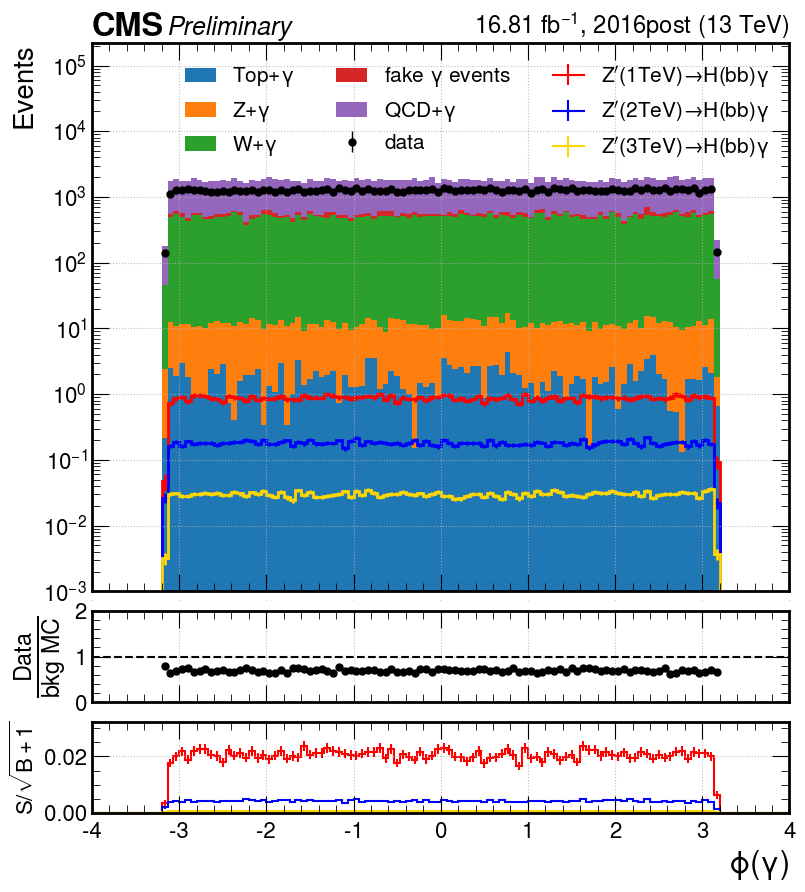

W+$\gamma$ [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.20604682e+02 2.33786320e+02 1.43923807e+02
 1.01917872e+02 5.51298731e+01 3.40657016e+01 2.29086978e+01
 1.50055031e+01 1.12756924e+01 7.36745562e+00 6.10113417e+00
 3.01916904e+00 2.64968435e+00 2.28579896e+00 6.75629698e-01
 1.20809403e+00 5.07513349e-01 6.80669791e-01 2.75636986e-01
 5.62300396e-01 3.41794415e-01 8.94538581e-02 1.28613680e-01
 8.46674109e-02 1.25409247e-01 1.91435009e-01 0.00000000e+00
 1.05258303e-01 5.58646243e-02 8.64640657e-02 0.00000000e+00
 5.28664814e-02 5.28108179e-02 0.00000000e+00 1.19406251e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.14379554e-02 0.00000000e+00 4.39138949e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


/tmp/ipykernel_3317930/4087906678.py:57: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid v

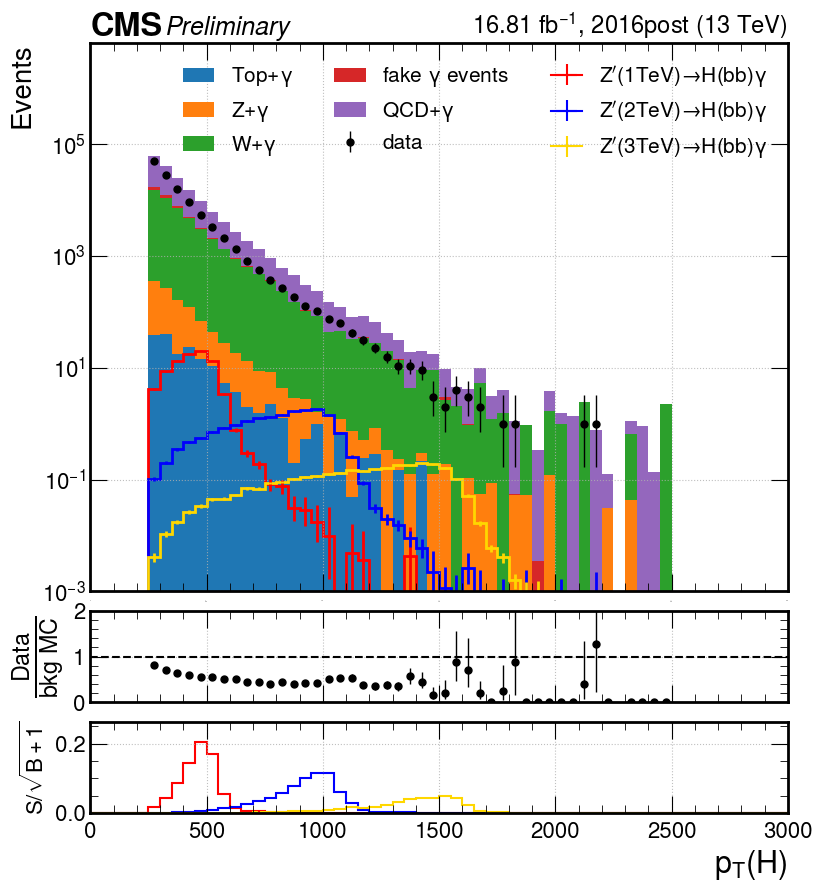

W+$\gamma$ [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.15259758  1.76652135
  3.20357632  3.48199741  2.31702714  4.05250566  5.48326362  4.6392739
  5.84412014  5.14409474  6.2589802   6.48717324  5.52581594  6.80025805
  7.11949332  9.07114497  8.58230022  8.61371596  9.59313936  8.40502002
 10.76958494  9.93070198 10.22092279 10.90669938 10.46500796 12.78195305
 10.7826667   9.05056978 10.24466059 11.8032873  12.74511074 10.93162442
 13.00111681 10.84284731 14.01054081 14.02945486 12.32302412 10.02211534
 11.69843002 11.30268333 14.3983098  12.49423356 14.06846105 11.72977463
 13.39246097 14.76912643 14.51577123 15.64328201 14.96342712 12.0373974
 14.36321922 14.09294247 13.46800466 12.04210435 15.18505679 15.27984038
 11.99749027 12.24245727 12.26935221 12.03058627 13.22823677 11.26994493
 13.08482522 12.60093763 15.29517509 13.94100211 12.04327576 13.8409439
 12.461179   11.40631192 13.78173574 11.68489228 10

/tmp/ipykernel_3317930/4087906678.py:57: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid v

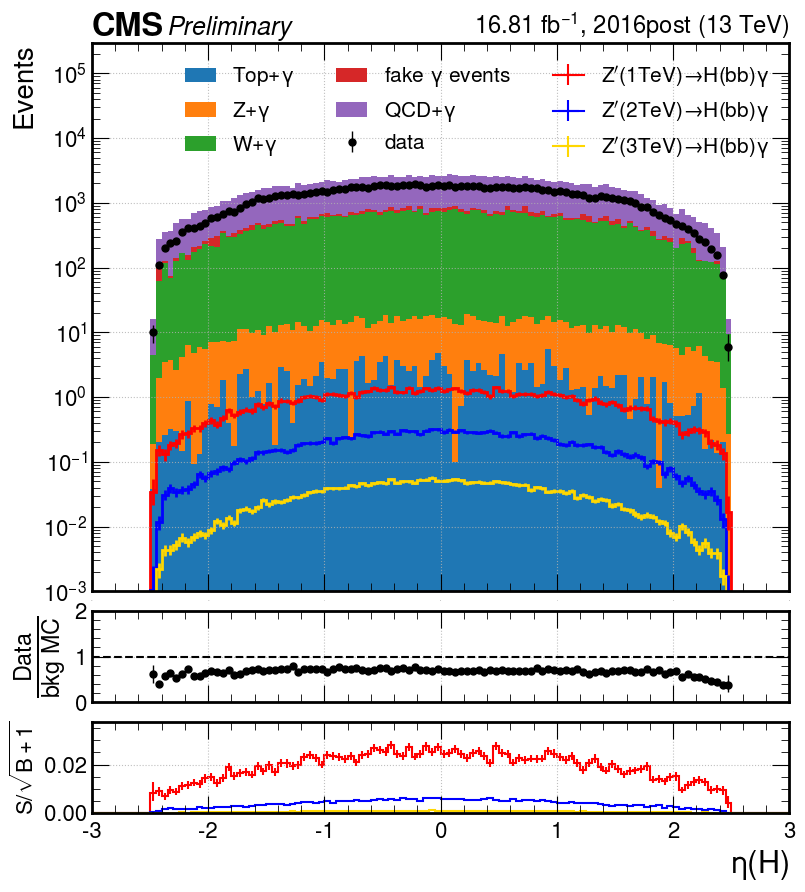

W+$\gamma$ [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.66873928 12.47622483 10.10774753 11.39140603 10.69151258 10.49253232
 12.87950107  9.30167284 10.84079714 11.87904535 10.65901867 11.08777276
 10.13346389  8.69060387 10.00048658  9.42099    10.80487316 12.51473627
 11.04254741  9.50164511 11.13385505 10.45398466  9.87481304 10.43573236
  9.78332323  9.08928223 10.68882129 11.17664895  9.90892695  8.54781195
 12.53968708 10.51780788  9.99063506  7.80471268  8.97749384 11.86516726
  9.51058125  9.79914617  9.79280447 10.55201411 12.48068126  9.86890488
  8.00596686  7.25527122  9.66245289  9.32275957 12.42053331 13.19504794
 10.27577176  8.38693605  9.62434484 11.26879857  7.95138132 10.85393157
 10.08017639  8.99135905  8.61161392 10.04121697 11.84862584 10.07301565
 10.76259965 11.39460398 11.1246046   9.09382555  9.94192883  8.47136906
 11.18897745  9.36854767  9.61302221  9.80673739 11.1139

/tmp/ipykernel_3317930/4087906678.py:57: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid v

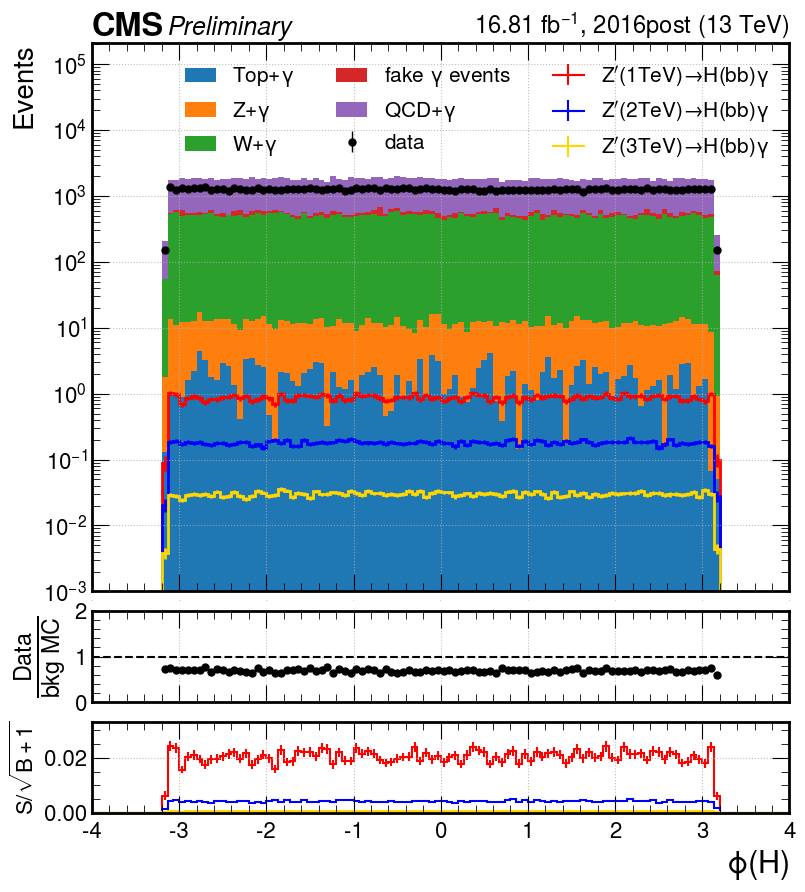

W+$\gamma$ [2.52432431e+01 2.29492531e+01 1.94454548e+01 2.29503660e+01
 2.00830365e+01 2.01135711e+01 2.34066398e+01 2.60928468e+01
 3.09127278e+01 3.48126468e+01 4.51115813e+01 7.39058095e+01
 1.02627883e+02 1.26936717e+02 1.12428476e+02 7.74891516e+01
 5.10182689e+01 2.86322463e+01 1.65936136e+01 1.30363275e+01
 1.01483169e+01 6.97813240e+00 6.76971162e+00 5.99764151e+00
 5.42593278e+00 4.92560496e+00 3.83312430e+00 3.88166529e+00
 2.57101928e+00 9.57702915e-01 2.63387893e+00 2.11859298e+00
 1.00408866e+00 1.31131182e+00 1.27498041e+00 9.20796637e-01
 9.67853894e-01 4.19953332e-01 1.52419393e+00 1.06478193e+00
 5.18398267e-01 4.29357461e-01 3.58364699e-01 2.90683734e-01
 3.16244023e-01 1.68278072e-01 1.88105866e-01 5.08807459e-01
 3.78732059e-01 2.94892065e-01 1.69813708e-01 2.62390248e-01
 2.34141141e-03 2.39224960e+00]


/tmp/ipykernel_3317930/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3317930/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3317930/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


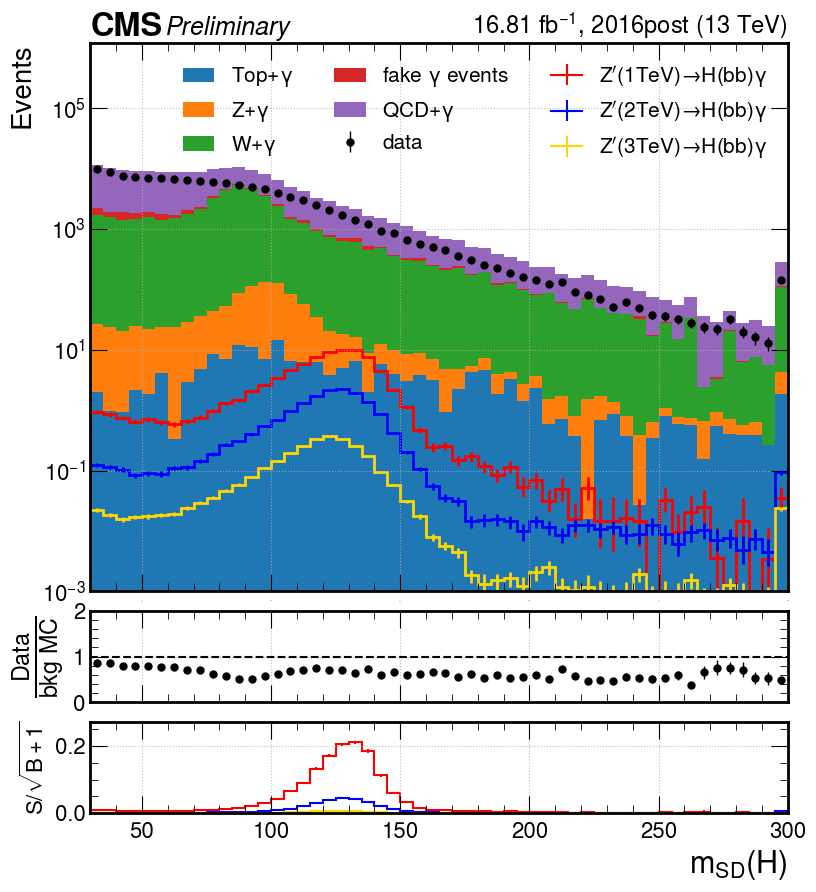

In [38]:
for y in events:
    if y != '2016post':
        continue
    arrays={k: events[y][k]['AK8jet_rankToHiggsMass'] for k in events[y]}
    data_mc_compare_plot(arrays, x_name=r'rank($|m_{SD}^{jet}-m_H|$) of the selected Higgs jet', plot_name='AK8jet_rankToHiggsMass', x_max=4, bins=4, weight=weight[y], year=y, fraction_log=False)
    arrays={k: events[y][k].photon_pt for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='photon_pt', x_name=r'$p_T(\gamma)$', x_max=3000, x_min=0, bins=100, weight=weight[y], year=y)
    arrays={k: events[y][k].photon_eta for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='photon_eta', x_name=r'$\eta(\gamma)$', x_max=3, x_min=-3, bins=120, weight=weight[y], year=y)
    arrays={k: events[y][k].photon_phi for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='photon_phi', x_name=r'$\phi(\gamma)$', x_max=4, x_min=-4, bins=120, weight=weight[y], year=y)
    arrays={k: events[y][k].AK8jet_pt for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='AK8jet_pt', x_name=r'$p_T(H)$', x_max=3000, x_min=0, bins=60, weight=weight[y], year=y)
    arrays={k: events[y][k].AK8jet_eta for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='AK8jet_eta', x_name=r'$\eta(H)$', x_max=3, x_min=-3, bins=120, weight=weight[y], year=y)
    arrays={k: events[y][k].AK8jet_phi for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='AK8jet_phi', x_name=r'$\phi(H)$', x_max=4, x_min=-4, bins=120, weight=weight[y], year=y)
    arrays={k: events[y][k].AK8jet_msoftdrop for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='AK8jet_msoftdrop', x_name=r'$m_{SD}(H)$', x_max=300, x_min=30, bins=54, weight=weight[y], year=y)

/tmp/ipykernel_3642827/710327429.py:59: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid va

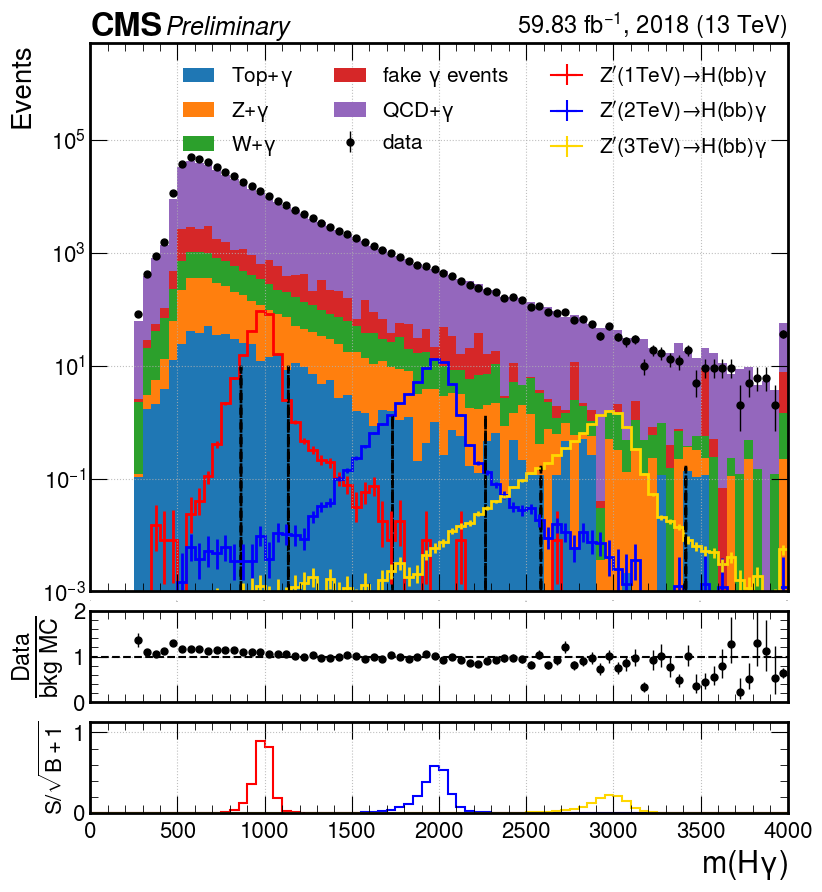

/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


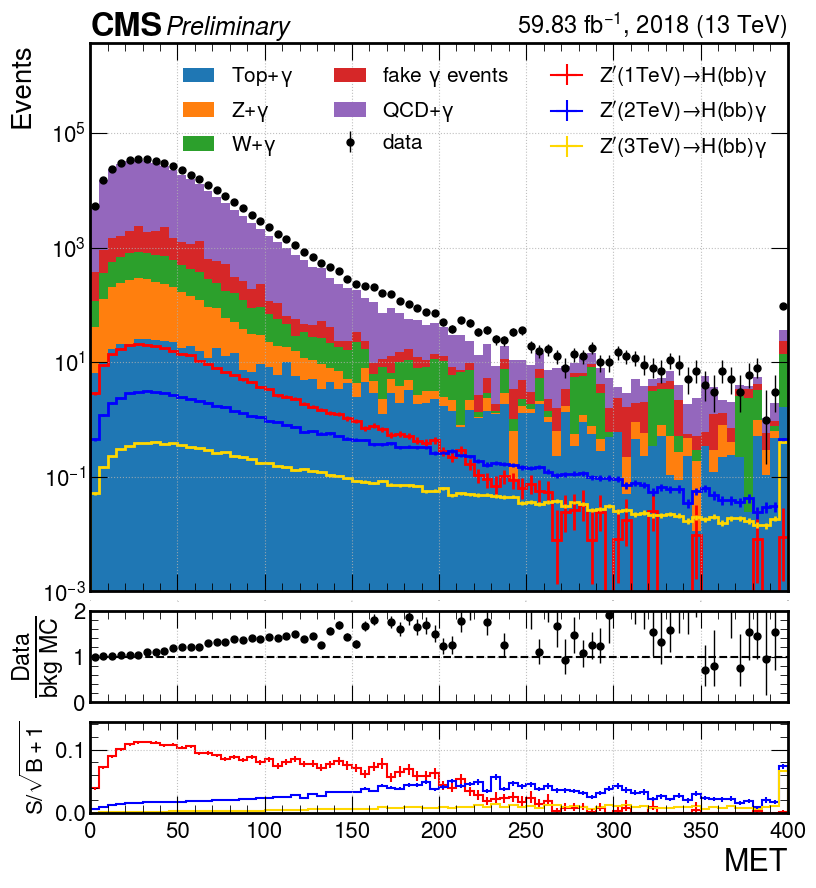

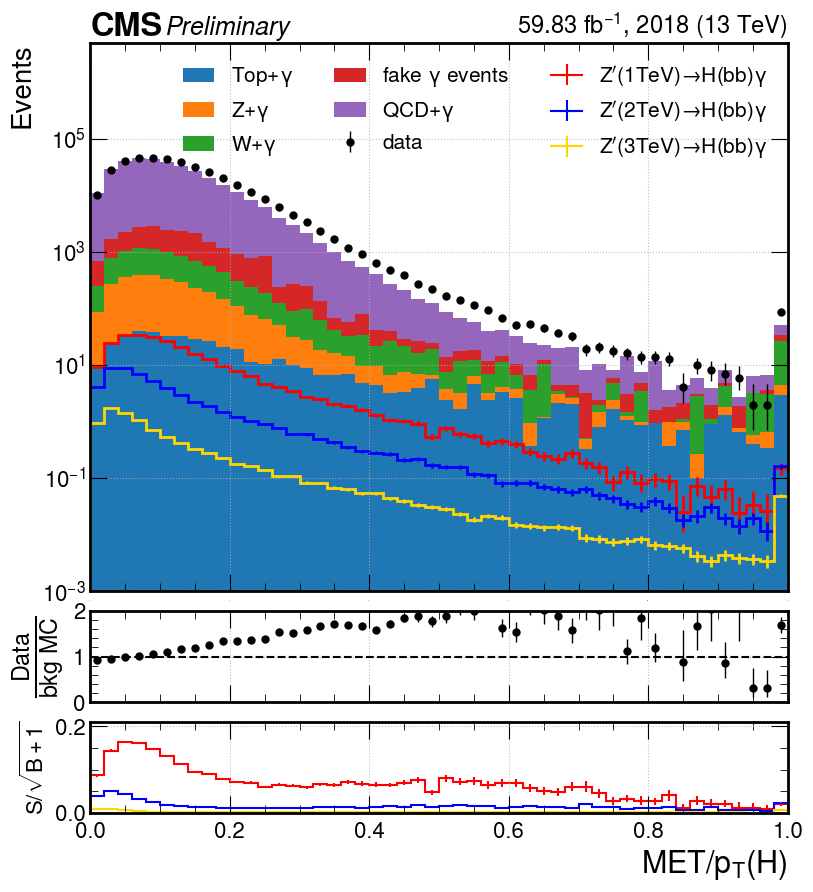

/tmp/ipykernel_3642827/710327429.py:59: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid va

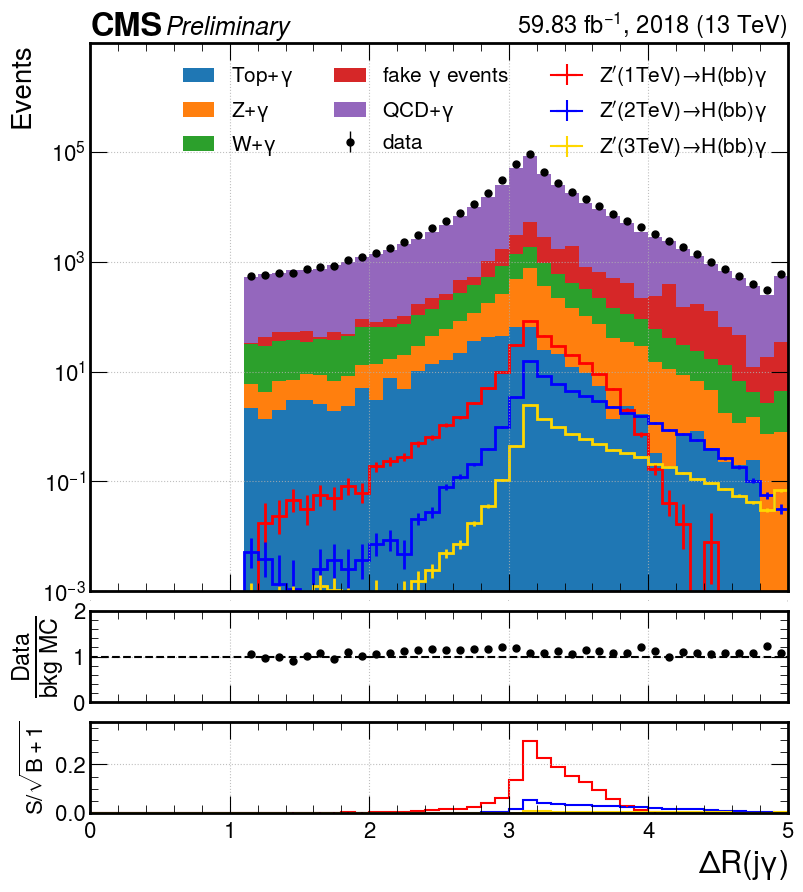

/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid v

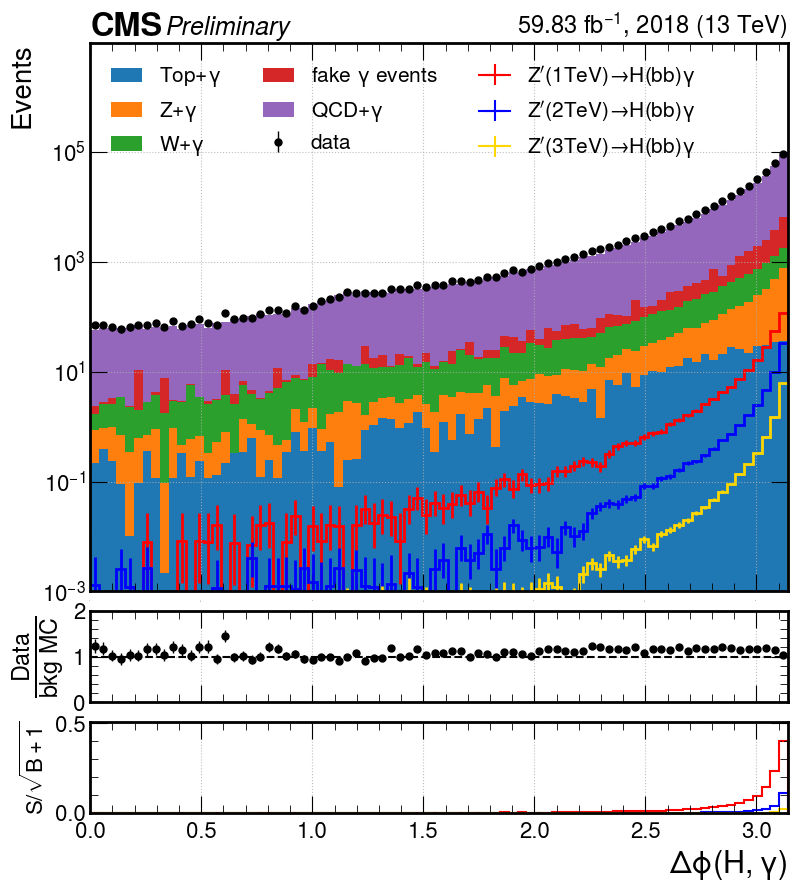

/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


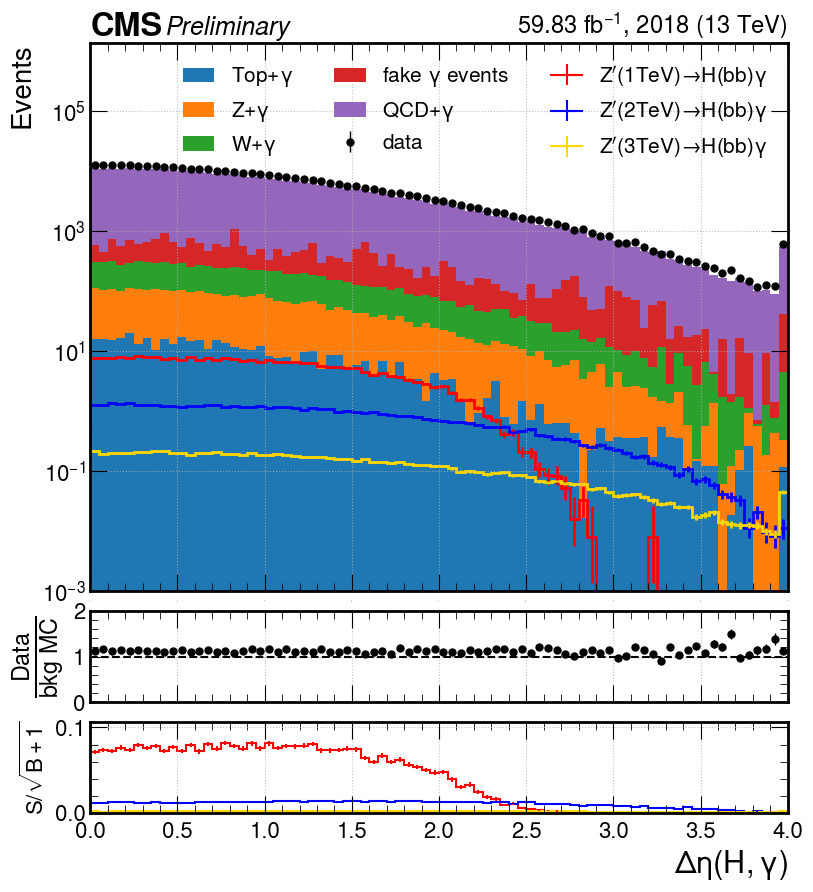

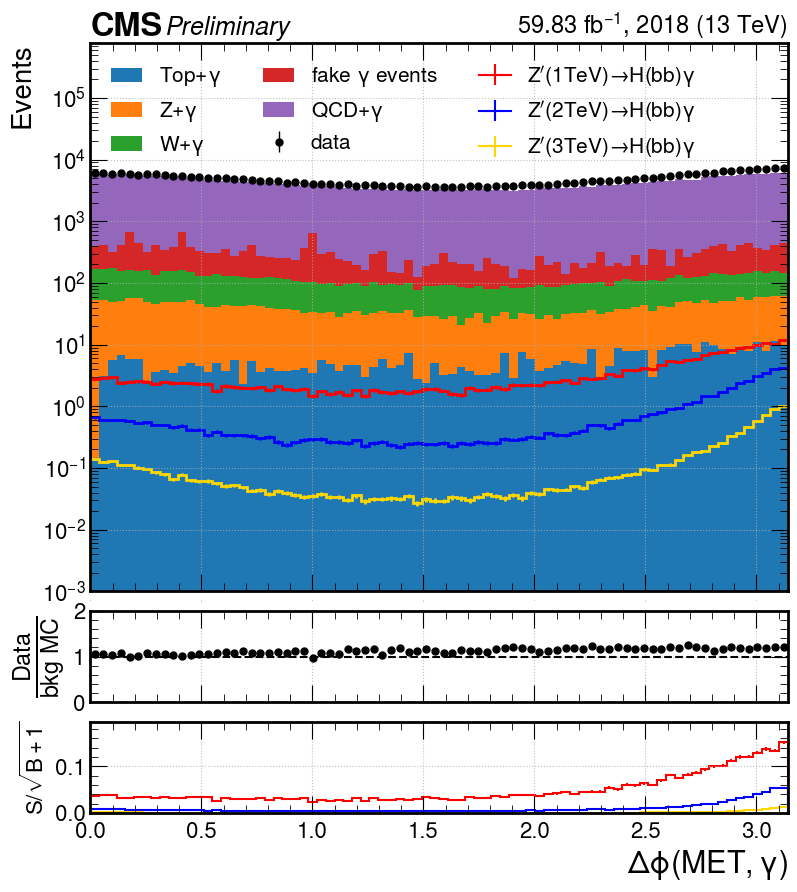

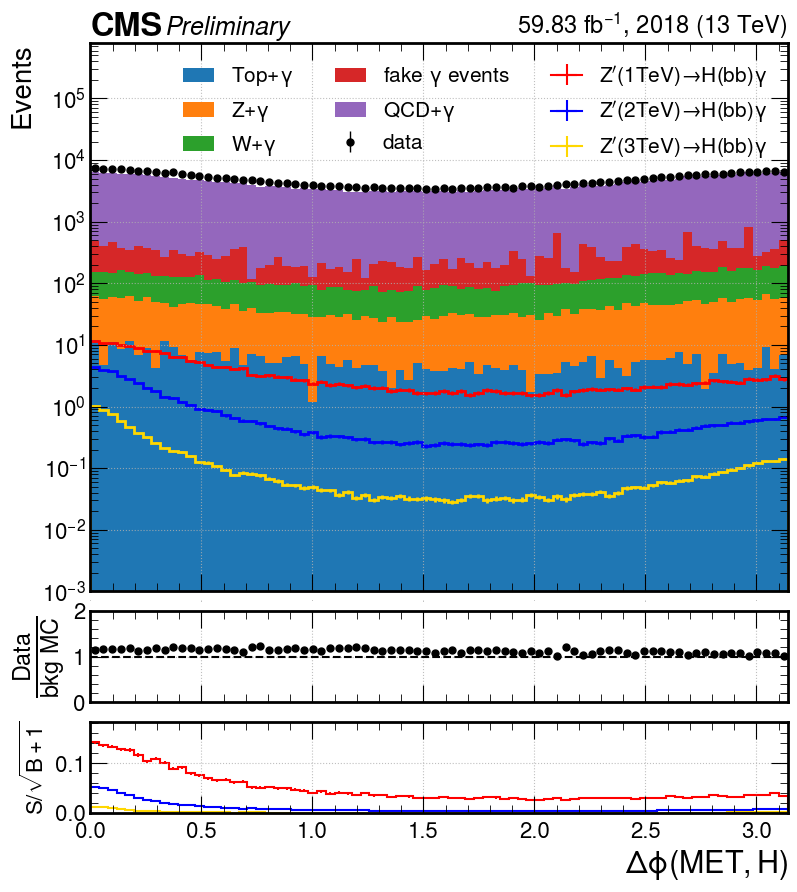

/tmp/ipykernel_3642827/710327429.py:59: RuntimeWarning: divide by zero encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_3642827/710327429.py:59: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/home/dfu/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3648: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_ba

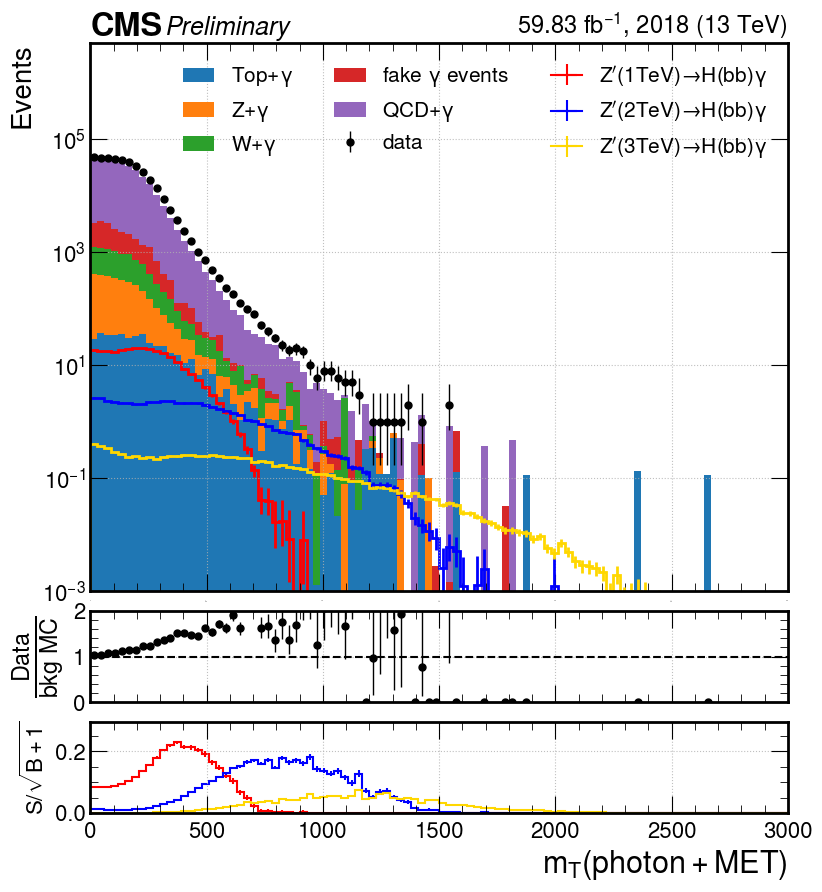

/tmp/ipykernel_3642827/710327429.py:59: RuntimeWarning: divide by zero encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_3642827/710327429.py:59: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/home/dfu/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3648: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_ba

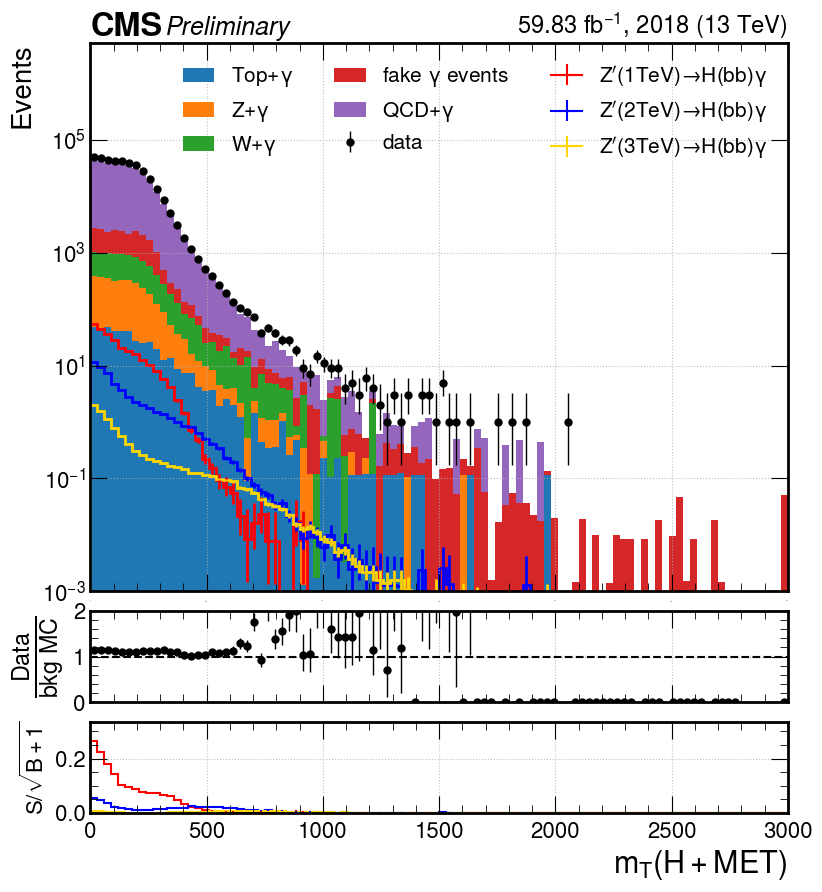

/tmp/ipykernel_3642827/710327429.py:59: RuntimeWarning: divide by zero encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_3642827/710327429.py:59: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/home/dfu/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3648: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_ba

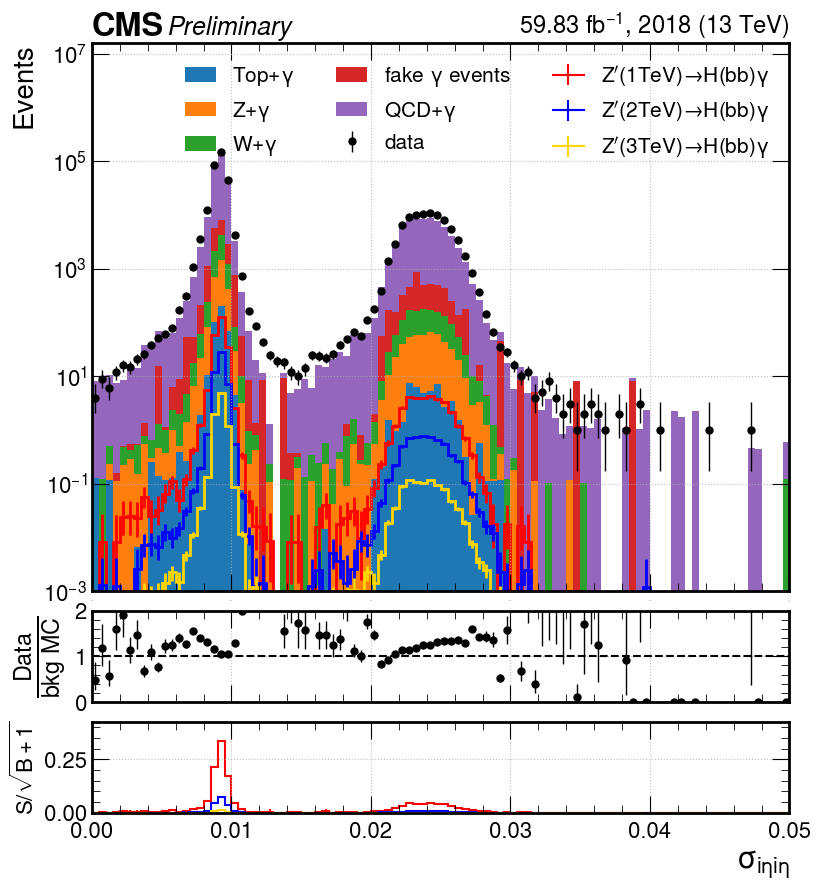

In [8]:
for y in events:
    arrays={k: events[y][k]['photon+jet_mass'] for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='photon+jet_mass', x_name=r'$m(H\gamma)$', x_max=4000, bins=80, weight=weight[y], year=y, mass_window=True)
    arrays={k: events[y][k]['event_MET_pt'] for k in events[y]}
    data_mc_compare_plot(arrays, x_name='MET', plot_name='event_MET_pt', x_max=400, bins=80, weight=weight[y], year=y, fraction_log=False)
    arrays={k: events[y][k].event_MET_pt/events[y][k].AK8jet_pt for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='MET_over_AK8jet_pt', x_name=r'$MET/p_T(H)$', x_max=1, x_min=0, bins=50, weight=weight[y], year=y, fraction_log=False)
    arrays={k: events[y][k]['photon-jet_deltaR'] for k in events[y]}
    data_mc_compare_plot(arrays, x_name=r'$\Delta R(j\gamma)$', plot_name='photon-jet_deltaR', x_max=5, bins=50, weight=weight[y], year=y)
    arrays={k: np.min([abs(events[y][k].photon_phi - events[y][k].AK8jet_phi), 2*np.pi - abs(events[y][k].photon_phi - events[y][k].AK8jet_phi)], axis=0) for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='photon-jet_delta_phi', x_name=r'$\Delta\phi(H, \gamma)$', x_max=np.pi, x_min=0, bins=80, weight=weight[y], year=y)
    arrays={k: abs(events[y][k].photon_eta - events[y][k].AK8jet_eta) for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='photon-jet_delta_eta', x_name=r'$\Delta\eta(H, \gamma)$', x_max=4, x_min=0, bins=80, weight=weight[y], year=y)
    arrays={k: np.min([abs(events[y][k].photon_phi - events[y][k].event_MET_phi), 2*np.pi - abs(events[y][k].photon_phi - events[y][k].event_MET_phi)], axis=0) for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='MET-photon_delta_phi', x_name=r'$\Delta\phi(MET,\gamma)$', x_max=np.pi, x_min=0, bins=80, weight=weight[y], year=y)
    arrays={k: np.min([abs(events[y][k].AK8jet_phi - events[y][k].event_MET_phi), 2*np.pi - abs(events[y][k].AK8jet_phi - events[y][k].event_MET_phi)], axis=0) for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='MET-AK8jet_delta_phi', x_name=r'$\Delta\phi(MET, H)$', x_max=np.pi, x_min=0, bins=80, weight=weight[y], year=y)
    arrays={k: events[y][k]['MET+photon_mT'] for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='MET+photon_mT', x_name=r'$m_T(photon+MET)$',  x_max=3000, bins=100, weight=weight[y], year=y)
    arrays={k: events[y][k]['MET+AK8jet_mT'] for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='MET+AK8jet_mT', x_name=r'$m_T(H+MET)$', x_max=3000, bins=100, weight=weight[y], year=y, fraction_log=False)
    arrays={k: events[y][k]['photon_sieie'] for k in events[y]}
    data_mc_compare_plot(arrays, plot_name='photon_sieie', x_name=r'$\sigma_{i\eta i\eta}$', x_max=0.05, x_min=0, bins=100, weight=weight[y], year=y, fraction_log=False)

## $MET/p_T$ study

In [13]:
import plotly.express as px
import pandas as pd

y='2018'
arrays={k: events[y][k].event_MET_pt/events[y][k].AK8jet_pt for k in events[y]}
low={k: ak.sum(arrays[k]<0.3) for k in arrays}
medium={k: ak.sum((arrays[k]>0.3)&(arrays[k]<0.6)) for k in arrays}
high={k: ak.sum(arrays[k]>0.6) for k in arrays}

df = pd.DataFrame({
    'component': [k for k in arrays if k not in ['data', 'Zp(2TeV)ToHG']], 
    'MET/p_T^j<0.3': [ak.sum((arrays[k]<0.3)*weight['2018'][k]) for k in arrays if k not in ['data', 'Zp(2TeV)ToHG']],
    '0.3<MET/p_T^j<0.6': [ak.sum(((arrays[k]>0.3)&(arrays[k]<0.6))*weight['2018'][k]) for k in arrays if k not in ['data', 'Zp(2TeV)ToHG']],
    'MET/p_T^j>0.6': [ak.sum((arrays[k]>0.6)*weight['2018'][k]) for k in arrays if k not in ['data', 'Zp(2TeV)ToHG']],
})

fig = px.pie(df, values='MET/p_T^j<0.3', names='component', color='component', title='MET/p_T(j)<0.3')
fig.update_layout(autosize=False, width=600, height=500,margin=dict(l=20, r=20, t=40, b=20),)
fig.show()
#fig.write_image('./plots/low.png')
fig = px.pie(df, values='0.3<MET/p_T^j<0.6', names='component', color='component', title='0.3<MET/p_T(j)<0.6')
fig.update_layout(autosize=False, width=600, height=500,margin=dict(l=20, r=20, t=40, b=20),)
fig.show()
#fig.write_image('./plots/medium.png')
fig = px.pie(df, values='MET/p_T^j>0.6', names='component', color='component', title='MET/p_T(j)>0.6')
fig.update_layout(autosize=False, width=600, height=500,margin=dict(l=20, r=20, t=40, b=20),)
fig.show()
#fig.write_image('./plots/high.png')

In [43]:
#arrays = {k: events['2018'][k]['photon-jet_mass'] for k in events['2018']}
#for k in set(arrays.keys()):
    if k.startswith('Zp'):
        arrays[k.replace('HG', 'H(WW)G')] = arrays[k][
            events['2018'][k]['gen_ZpToH(WW)Gamma'] & 
            (events['2018'][k].event_MET_pt/events['2018'][k].AK8jet_pt > 0.6)
        ]
        weight['2018'].update({
            k.replace('HG', 'H(WW)G'): events['2018'][k].event_weight[
                events['2018'][k]['gen_ZpToH(WW)Gamma'] & 
                (events['2018'][k].event_MET_pt/events['2018'][k].AK8jet_pt > 0.6)
            ]
        })
        del arrays[k]
    else:
        arrays[k] = arrays[k][
            (events['2018'][k].event_MET_pt/events['2018'][k].AK8jet_pt > 0.6)
        ]
        if k=='data':
            continue
        weight['2018'].update({
            k: events['2018'][k].event_weight[
                (events['2018'][k].event_MET_pt/events['2018'][k].AK8jet_pt > 0.6)
            ]
        })
        
        
data_mc_compare_plot(arrays, plot_name='high_MET_photon-jet_mass', x_name=r'$m_{j\gamma}$', x_max=3500, bins=35, weight=weight['2018'], year='2018', density=False)
data_mc_compare_plot(arrays, plot_name='high_MET_photon-jet_mass', x_name=r'$m_{j\gamma}$', x_max=3500, bins=35, weight=weight['2018'], year='2018', density=True)

IndentationError: unexpected indent (2876207102.py, line 3)

# Optimizing

In [9]:
hep.style.use("CMS")

def signal_window_arrays(arrays: dict, weight: dict, event_cut: dict, bins: int=40, x_min: float=0, x_max: float=2000, overflow: bool=True, underflow: bool=False):
    cut, cut_arrays, cut_weight = {'h': {}, 'var': {}}, {}, {}
    
    for k, array in arrays.items():
        cut_arrays[k] = array[event_cut[k]]
        if k!='data':
            cut_weight[k] = weight[k][event_cut[k]]
    
    for (k, v) in cut_arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=cut_weight[k])
        else:
            hist.fill(values)
        cut['h'][k], cut['var'][k] = flow(hist=hist, overflow=overflow, underflow=underflow)

    return cut['h'], cut['var']
    

def optimizing_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=40, x_min=0, x_max=2000, density=True, overflow=True, underflow=False, fraction_log=False, mode: str='less'):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        _weight = {k: weight[k][cuts[k]] for k in arrays if k in weight}
        _events = {k: events[year][k][cuts[k]] for k in arrays}
    else:
        _weight = {k: weight[k] for k in arrays if k in weight}
        _events = {k: events[year][k] for k in arrays}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.2)
    ax = f.add_subplot(gs[0])
    #ax = plt.gca()
    plt.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
 
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
        if k!='data':
            hist.fill(values, weight=_weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var


    ## plot
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=['darkorange', 'cyan', 'HotPink', 'darkviolet', 'SlateGray', 'black', 'LightSkyBlue'])
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=False, stack=True, linewidth=2, ax=ax)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
    
    for (k, h) in individual['h'].items():
        if k=='data':
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k+r'($m_H$ sideband)', color='black', histtype='errorbar', density=False, stack=False, ax=ax)
        elif k in SIG_COLOR:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            
            ## begin optimizing plot
            mass_center = float(k.split('(')[1][0]) * 1e3
            mass_std = ak.std(_events[k]['photon+jet_mass'], weight=_weight[k])
            cut_h, cut_var = signal_window_arrays(
                arrays=arrays, weight=_weight, event_cut={
                    k: (_events[k]['photon+jet_mass'] > mass_center - 3*mass_std) & (_events[k]['photon+jet_mass'] < mass_center + 3*mass_std) for k in arrays
                }, bins=bins, x_min=x_min, x_max=x_max, overflow=overflow, underflow=underflow
            )
            cut_bkg_h = np.sum([h for k, h in cut_h.items() if k in BKG], axis=0)
            
            if mode=='less':
                y = [ak.sum(cut_h[k][:index]) / np.sqrt(ak.sum(cut_bkg_h[:index]) + 1) for index in range(bins)]
            elif mode=='greater':
                y = [ak.sum(cut_h[k][index:]) / np.sqrt(ak.sum(cut_bkg_h[index:]) + 1) for index in range(bins)]
            y_max_bin = np.argmax(y)
            hep.histplot(y, bins=hist.axes[0].edges, label=k, histtype='step', density=density, stack=False, ax=ax1, color=SIG_COLOR[k], linestyle='dashed')
            #plt.arrow(x=hist.axes[0].edges[y_max_bin], y=np.max(y), dx=0, dy=-np.max(y), length_includes_head=True, color=SIG_COLOR[k])

    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel(x_name, fontsize=20, ha='right', x=1)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-3, ax.get_ylim()[1]*1e2)
    ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)    
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)

    
    #ax1.set_yscale('log')
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0, ax1.get_ylim()[1]*1.2)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel('cut_value', fontsize=21, ha='right', x=1)
    ax1.set_ylabel('sensitivity'+('\n(A.U.)' if density else ''), ha='center', fontsize=16)
    ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots/optimize'):
        os.makedirs('./plots/optimize')
    plt.savefig(f"./plots/optimize/{year}_{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid v

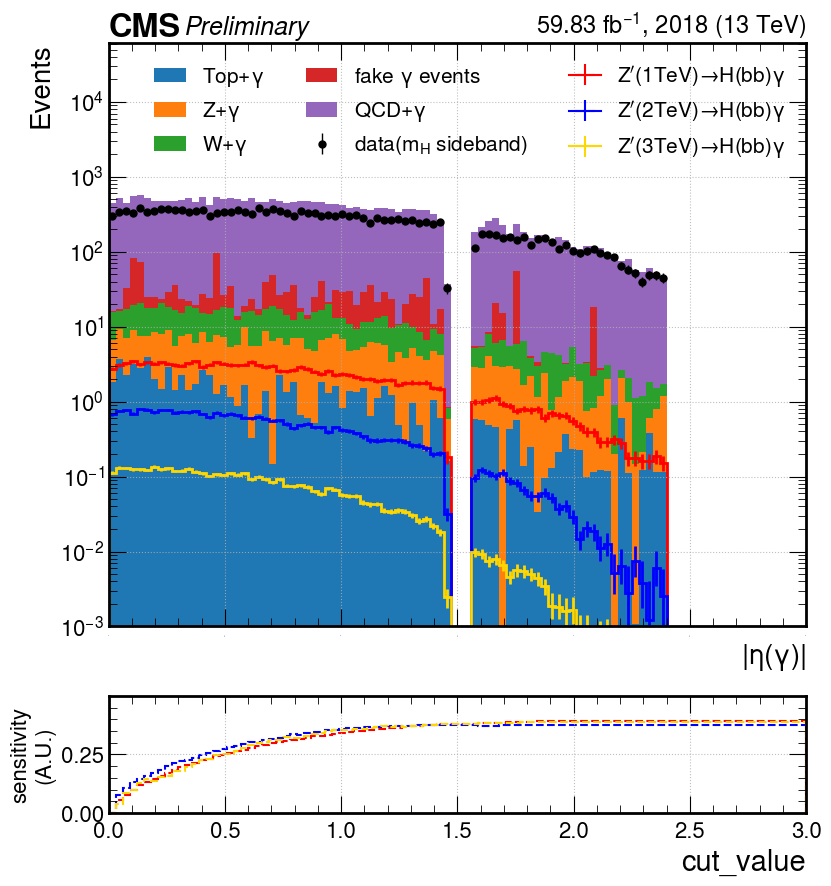

/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid v

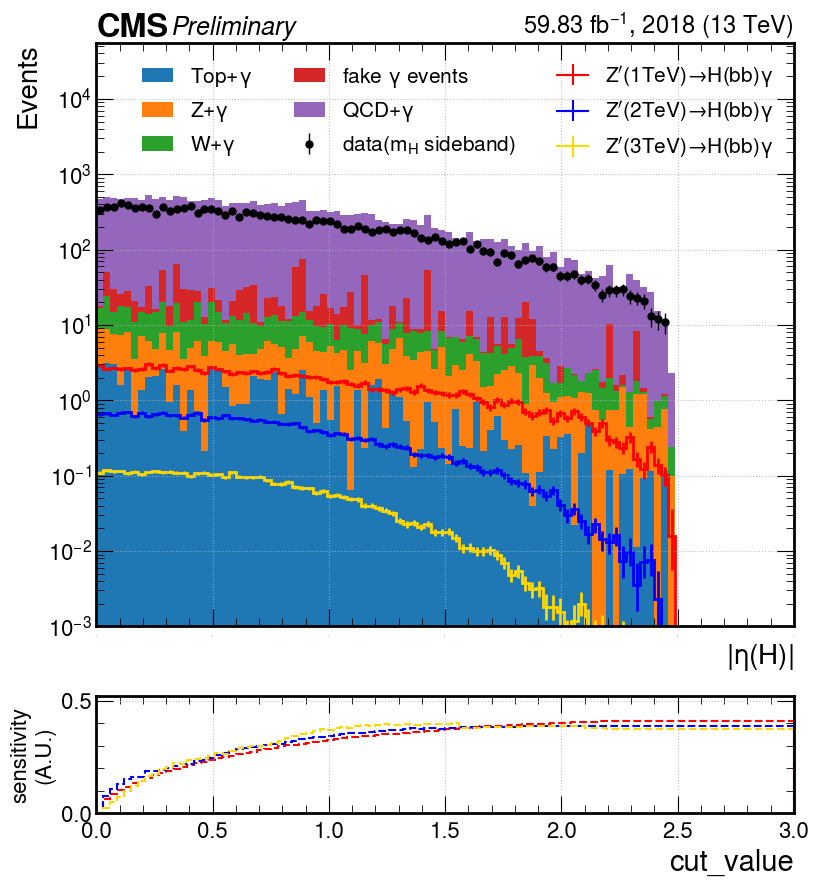

/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid v

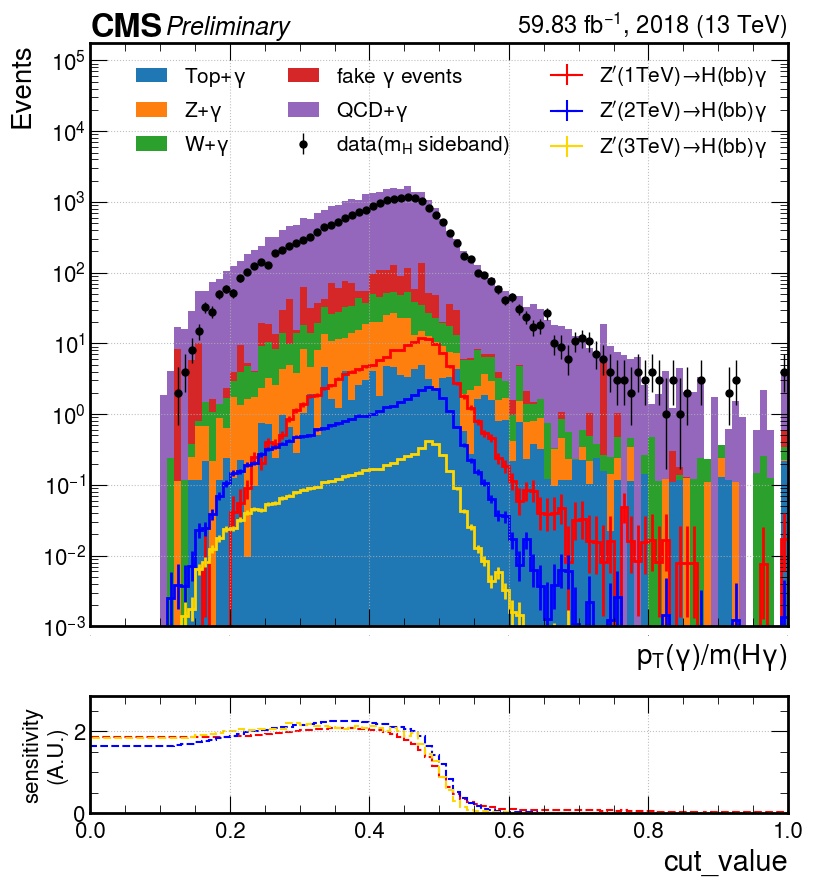

In [10]:
y='2018'
full_cuts = """{
k: ((events[y][k]['AK8jet_msoftdrop'] > 100) & (events[y][k]['AK8jet_msoftdrop'] < 110) if k=='data' else (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140)) &
(np.abs(events[y][k].photon_eta) < 1.4442) &
(np.abs(events[y][k].AK8jet_eta) < 2.4) &
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
for k in arrays
}"""

arrays={k: np.abs(events[y][k].photon_eta) for k in events[y]}
optimizing_plot(
    arrays, mode='less', cuts=eval(
        full_cuts.replace("(np.abs(events[y][k].photon_eta) < 1.4442) &", "")
    ), plot_name='abs_photon_eta', x_name=r'$|\eta(\gamma)|$', x_max=3, x_min=0, bins=100, weight=weight[y], year=y
)

arrays={k: np.abs(events[y][k].AK8jet_eta) for k in events[y]}
optimizing_plot(
    arrays, mode='less', cuts=eval(
        full_cuts.replace("(np.abs(events[y][k].AK8jet_eta) < 2.4) &", "")
    ), plot_name='abs_jet_eta', x_name=r'$|\eta(H)|$', x_max=3, x_min=0, bins=100, weight=weight[y], year=y
)

arrays={k: events[y][k].photon_pt/events[y][k]['photon+jet_mass'] for k in events[y]}
optimizing_plot(
    arrays, mode='greater', cuts=eval(
        full_cuts.replace("&\n(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)", "")
    ), plot_name='photon_pt_over_photon+jet_mass', x_name=r'$p_T(\gamma)/m(H\gamma)$', x_max=1, x_min=0, bins=100, weight=weight[y], year=y
)

/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid v

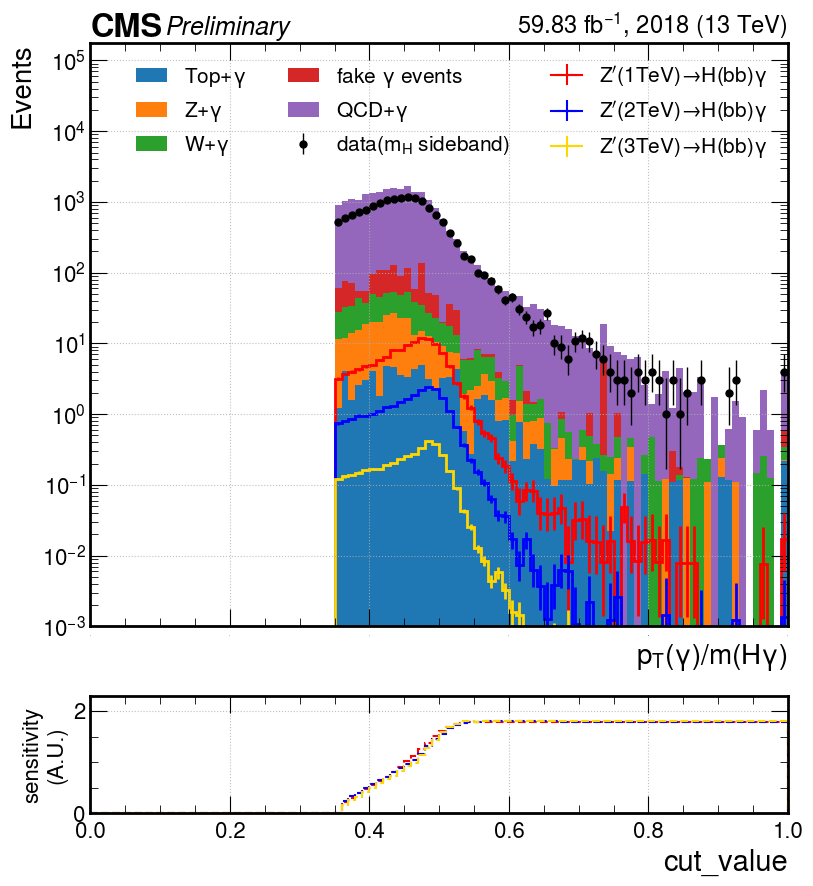

In [11]:
arrays={k: events[y][k].photon_pt/events[y][k]['photon+jet_mass'] for k in events[y]}
optimizing_plot(
    arrays, mode='less', cuts=eval(
        full_cuts.replace(" & (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] < 0.6)", "")
    ), plot_name='right_photon_pt_over_photon+jet_mass', x_name=r'$p_T(\gamma)/m(H\gamma)$', x_max=1, x_min=0, bins=100, weight=weight[y], year=y
)

In [12]:
y='2018'
k=r'$Z^\mathrm{\prime}(2TeV)\to H(bb)\gamma$'
np.corrcoef(x=np.abs(events[y][k].photon_eta - events[y][k].AK8jet_eta), y=events[y][k].photon_pt/events[y][k]['photon+jet_mass'])[0][1]

-0.9123411819878399

/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid v

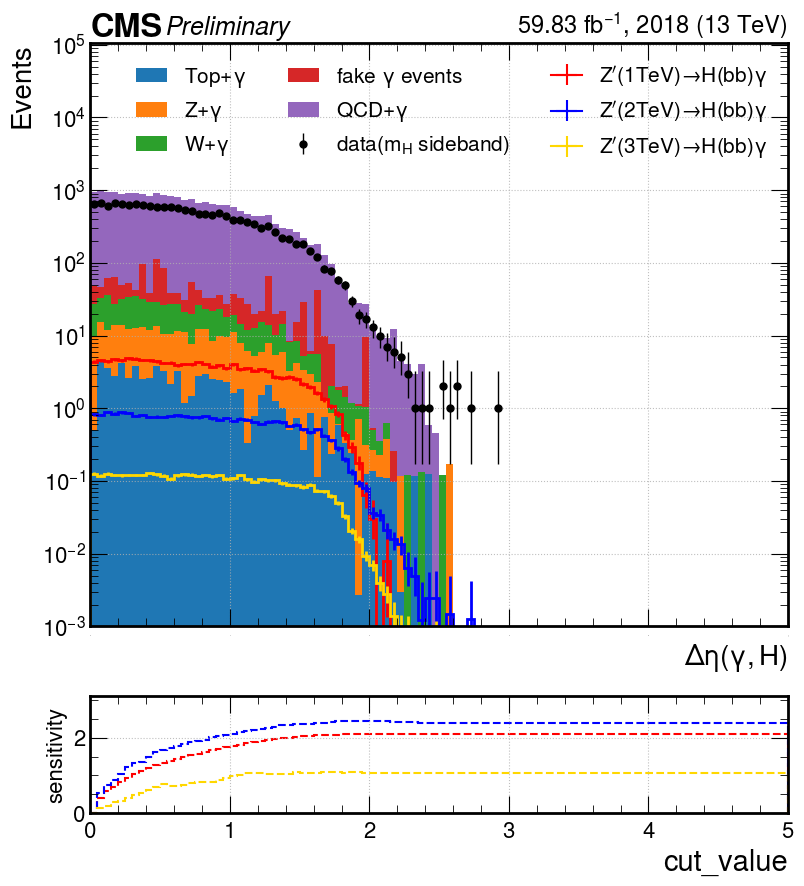

In [13]:
arrays={k: np.abs(events[y][k].photon_eta - events[y][k].AK8jet_eta) for k in events[y]}
optimizing_plot(
    arrays, mode='less', density=False, cuts=eval(
        full_cuts#.replace("&\n((events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] < 0.6))", "")
    ), plot_name='delta_eta_photon_jet', x_name=r'$\Delta\eta(\gamma, H)$', x_max=5, x_min=0, bins=100, weight=weight[y], year=y
)

# With full selection

## $Z^\prime$ mass window

/tmp/ipykernel_3642827/710327429.py:59: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid va

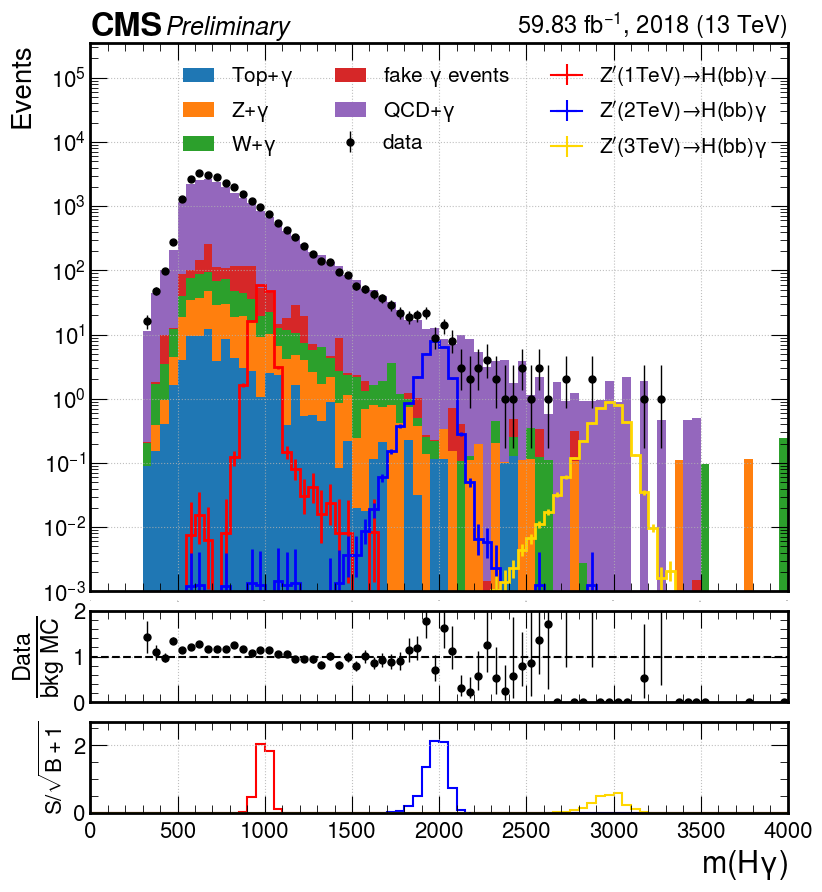

In [14]:
y = '2018'
arrays={
    k: events[y][k]['photon+jet_mass'][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}
data_mc_compare_plot(arrays, plot_name='full_photon+jet_mass', x_name=r'$m(H\gamma)$', x_max=4000, bins=80, weight=_weight, year=y, mass_window=False)

## $m_H$ distribution

/tmp/ipykernel_3642827/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_3642827/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_3642827/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


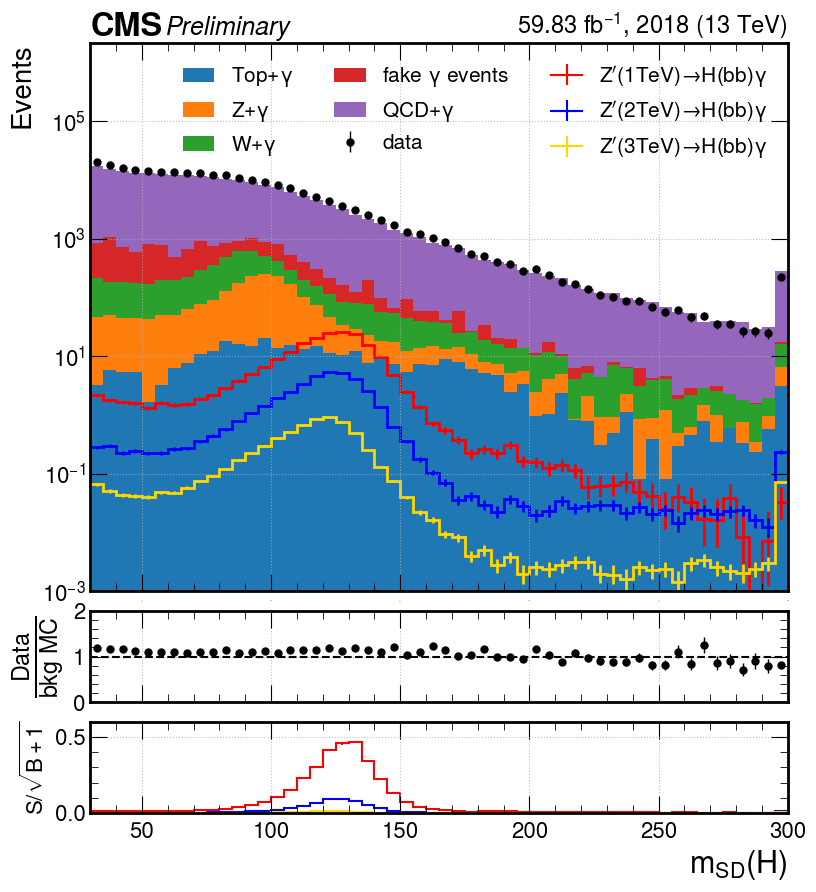

In [15]:
y = '2018'
arrays={
    k: events[y][k]['AK8jet_msoftdrop'][
        #(events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        #(events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}
data_mc_compare_plot(arrays, plot_name='full_AK8jet_msoftdrop', x_name=r'$m_{SD}(H)$', x_max=300, x_min=30, bins=54, weight=_weight, year=y, underflow=True)

In [17]:
ak.mean(
    np.concatenate([arrays[k][(arrays[k]<140)&(arrays[k]>110)] for k in BKG], axis=0), 
    weight=np.concatenate([_weight[k][(arrays[k]<140)&(arrays[k]>110)] for k in BKG], axis=0)
)

122.37008127922549

In [23]:
ak.mean(
    np.concatenate(
        [arrays[k][((arrays[k]<110)&(arrays[k]>100))|(arrays[k]<60)&(arrays[k]>50)|((arrays[k]<250)&(arrays[k]>140))] for k in BKG], axis=0
    ), weight=np.concatenate(
        [_weight[k][((arrays[k]<110)&(arrays[k]>100))|(arrays[k]<60)&(arrays[k]>50)|((arrays[k]<250)&(arrays[k]>140))] for k in BKG], axis=0
    )
)

94.01987147886295

In [18]:
hep.style.use("CMS")

def mH_mass_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False, mass_window=False):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
    
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Variable([100, 110, 140, 170]), storage=bh.storage.Weight())
        if 'delta_phi' in plot_name:
            values = np.min([v, 2*np.pi-v], axis=0)
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var
        
    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=density, stack=True, linewidth=2, ax=ax)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        # we usually don't care error of background MC cuz the stats is very large (relative error is very small compared with signal and data)
    for (k,h) in individual['h'].items():
        if k=='data':
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
        elif k in SIG_COLOR:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            if mass_window:
                mass_center = float(k.split('(')[1][:1])*1e3
                mass_std = ak.std(arrays[k], weight=weight[k])
                ax.arrow(x=mass_center - 2*mass_std, y=np.max(h)/10, dx=0, dy=1e-3-np.max(h)/10, length_includes_head=True, color='black', linewidth=2, linestyle='dashed')
                ax.arrow(x=mass_center + 2*mass_std, y=np.max(h)/10, dx=0, dy=1e-3-np.max(h)/10, length_includes_head=True, color='black', linewidth=2, linestyle='dashed')


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    #if not density:
    #    ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    
    #ax2.set_yscale('log')
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/{year}_{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()
    

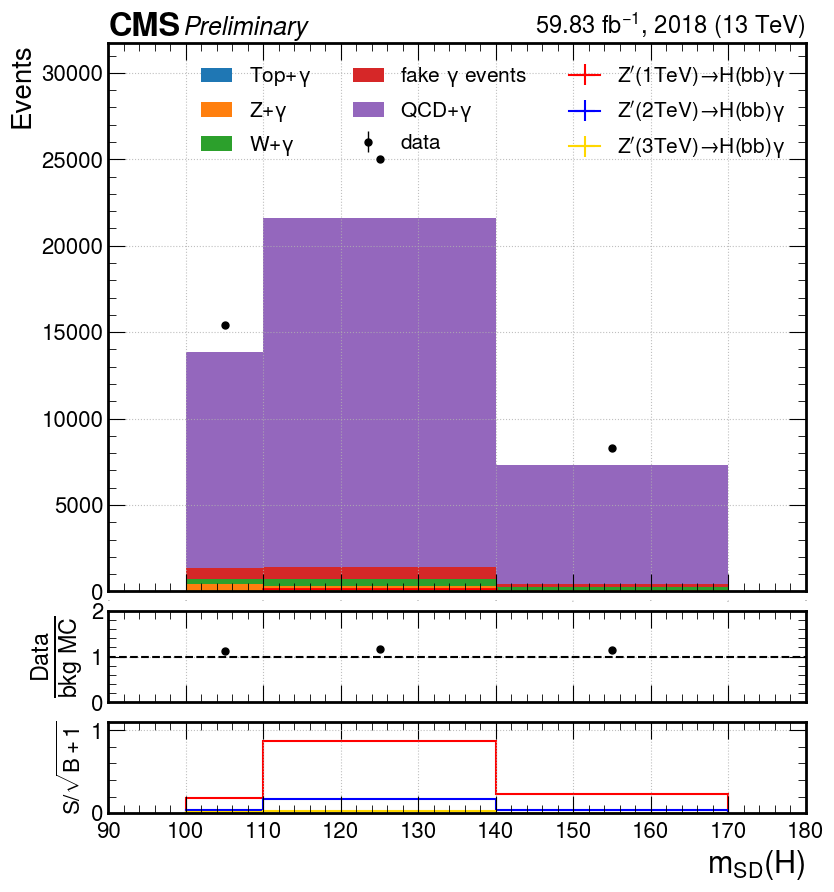

In [19]:
y = '2018'
arrays={
    k: events[y][k]['AK8jet_msoftdrop'][
        #(events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        #(events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}
mH_mass_plot(arrays, plot_name='mH_in_3_region', x_name=r'$m_{SD}(H)$', x_max=180, x_min=90, bins=54, weight=_weight, year=y)

# Tagger score study and Categorization

In [20]:
score_all = [
    'AK8jet_inclParTMDV1_probHWqqWev0c',
    'AK8jet_inclParTMDV1_probHWqqWev1c',
    'AK8jet_inclParTMDV1_probHWqqWmv0c',
    'AK8jet_inclParTMDV1_probHWqqWmv1c',
    'AK8jet_inclParTMDV1_probHWqqWq0c',
    'AK8jet_inclParTMDV1_probHWqqWq1c',
    'AK8jet_inclParTMDV1_probHWqqWq2c',
    'AK8jet_inclParTMDV1_probHWqqWqq0c',
    'AK8jet_inclParTMDV1_probHWqqWqq1c',
    'AK8jet_inclParTMDV1_probHWqqWqq2c',
    'AK8jet_inclParTMDV1_probHWqqWtauev0c',
    'AK8jet_inclParTMDV1_probHWqqWtauev1c',
    'AK8jet_inclParTMDV1_probHWqqWtauhv0c',
    'AK8jet_inclParTMDV1_probHWqqWtauhv1c',
    'AK8jet_inclParTMDV1_probHWqqWtaumv0c',
    'AK8jet_inclParTMDV1_probHWqqWtaumv1c',
    'AK8jet_inclParTMDV1_probHbb',
    'AK8jet_inclParTMDV1_probHcc',
    'AK8jet_inclParTMDV1_probHqq',
    'AK8jet_inclParTMDV1_probHss',
    'AK8jet_inclParTMDV1_probHtauhtaue',
    'AK8jet_inclParTMDV1_probHtauhtauh',
    'AK8jet_inclParTMDV1_probHtauhtaum',
    'AK8jet_inclParTMDV1_probQCDb',
    'AK8jet_inclParTMDV1_probQCDbb',
    'AK8jet_inclParTMDV1_probQCDc',
    'AK8jet_inclParTMDV1_probQCDcc',
    'AK8jet_inclParTMDV1_probQCDothers',
    'AK8jet_inclParTMDV1_probTopbWev',
    'AK8jet_inclParTMDV1_probTopbWmv',
    'AK8jet_inclParTMDV1_probTopbWq0c',
    'AK8jet_inclParTMDV1_probTopbWq1c',
    'AK8jet_inclParTMDV1_probTopbWqq0c',
    'AK8jet_inclParTMDV1_probTopbWqq1c',
    'AK8jet_inclParTMDV1_probTopbWtauev',
    'AK8jet_inclParTMDV1_probTopbWtauhv',
    'AK8jet_inclParTMDV1_probTopbWtaumv',
]

score_Higgs = [k for k in score_all if k.startswith('AK8jet_inclParTMDV1_probH')]

score_HWW = [
    'AK8jet_inclParTMDV1_probHWqqWev0c',
    'AK8jet_inclParTMDV1_probHWqqWev1c',
    'AK8jet_inclParTMDV1_probHWqqWmv0c',
    'AK8jet_inclParTMDV1_probHWqqWmv1c',
    'AK8jet_inclParTMDV1_probHWqqWq0c',
    'AK8jet_inclParTMDV1_probHWqqWq1c',
    'AK8jet_inclParTMDV1_probHWqqWq2c',
    'AK8jet_inclParTMDV1_probHWqqWqq0c',
    'AK8jet_inclParTMDV1_probHWqqWqq1c',
    'AK8jet_inclParTMDV1_probHWqqWqq2c',
    'AK8jet_inclParTMDV1_probHWqqWtauev0c',
    'AK8jet_inclParTMDV1_probHWqqWtauev1c',
    'AK8jet_inclParTMDV1_probHWqqWtauhv0c',
    'AK8jet_inclParTMDV1_probHWqqWtauhv1c',
    'AK8jet_inclParTMDV1_probHWqqWtaumv0c',
    'AK8jet_inclParTMDV1_probHWqqWtaumv1c',
]

score_QCD = [
    'AK8jet_inclParTMDV1_probQCDb',
    'AK8jet_inclParTMDV1_probQCDbb',
    'AK8jet_inclParTMDV1_probQCDc',
    'AK8jet_inclParTMDV1_probQCDcc',
    'AK8jet_inclParTMDV1_probQCDothers',
]

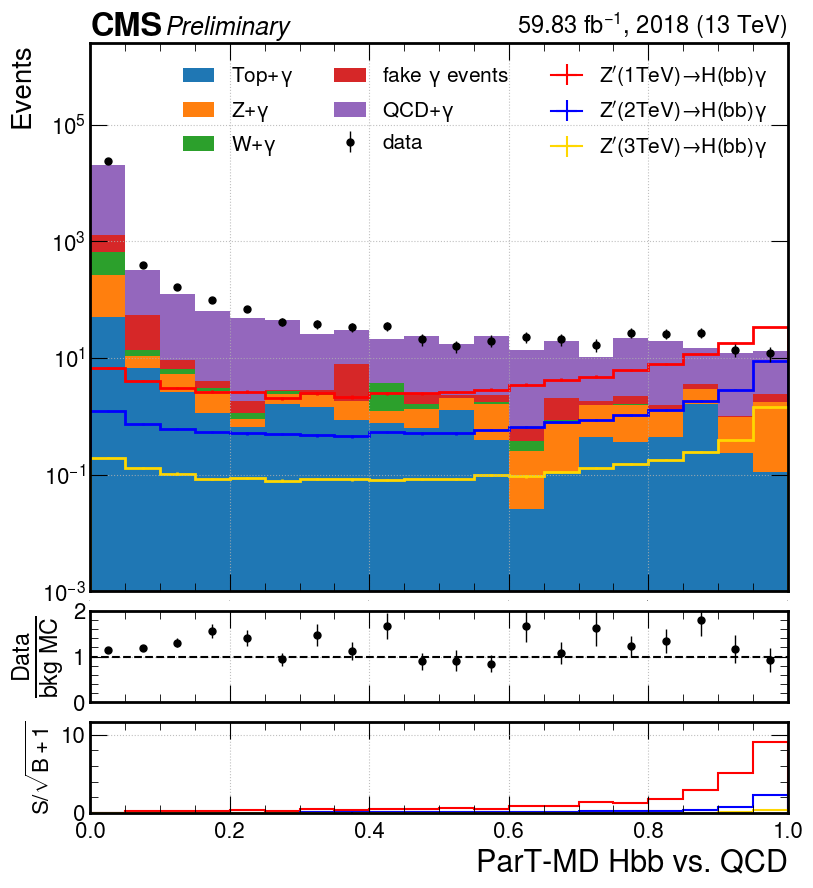

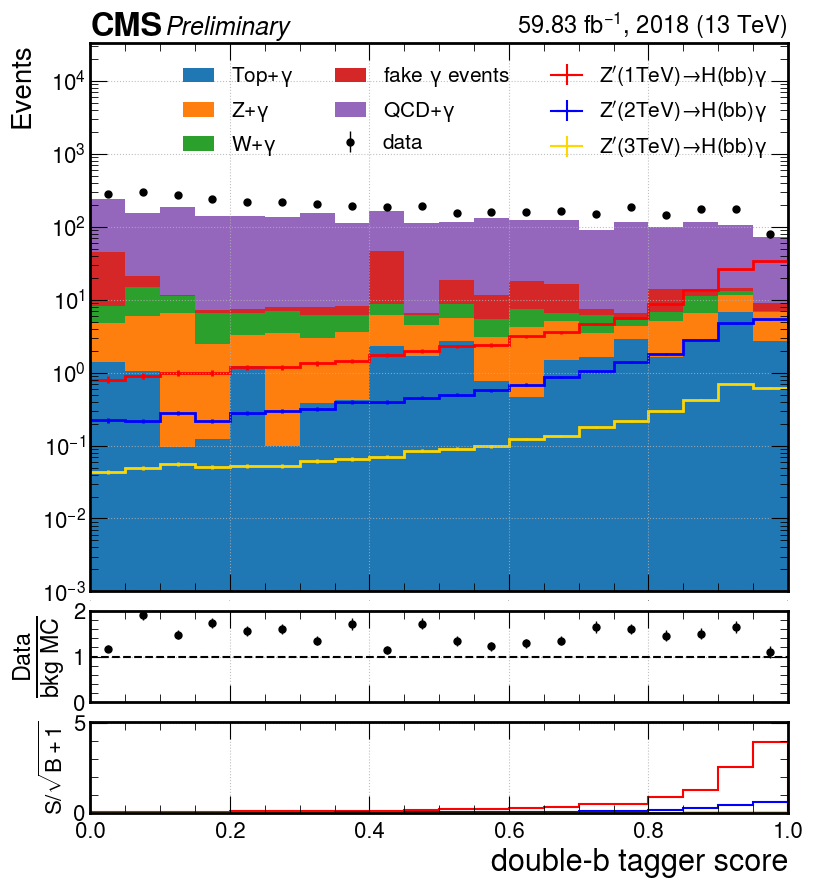

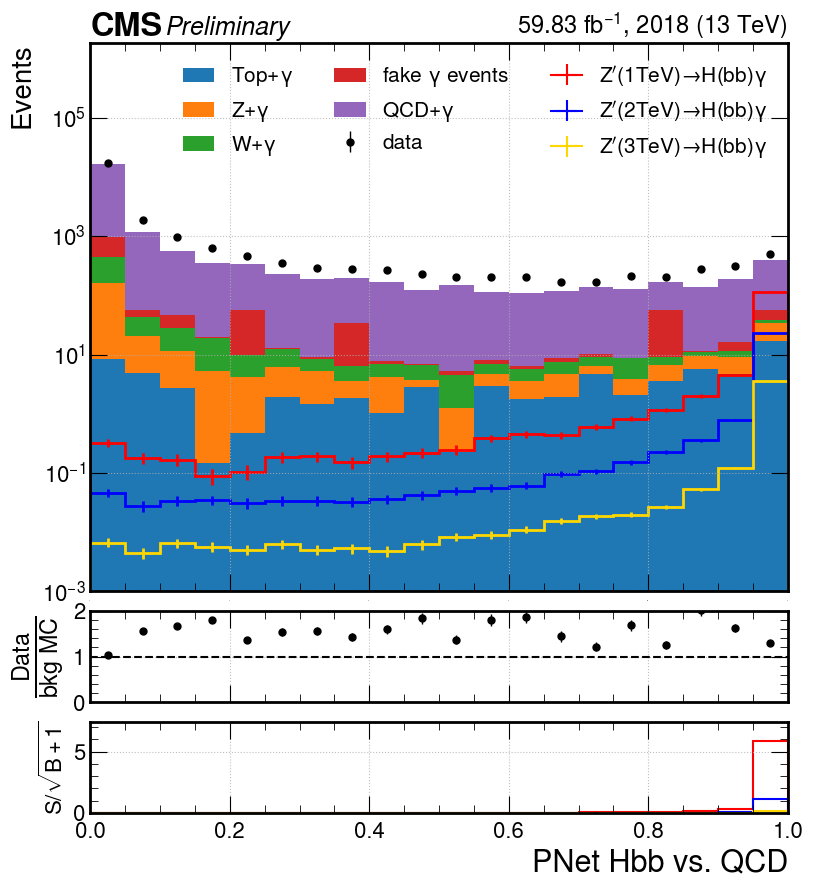

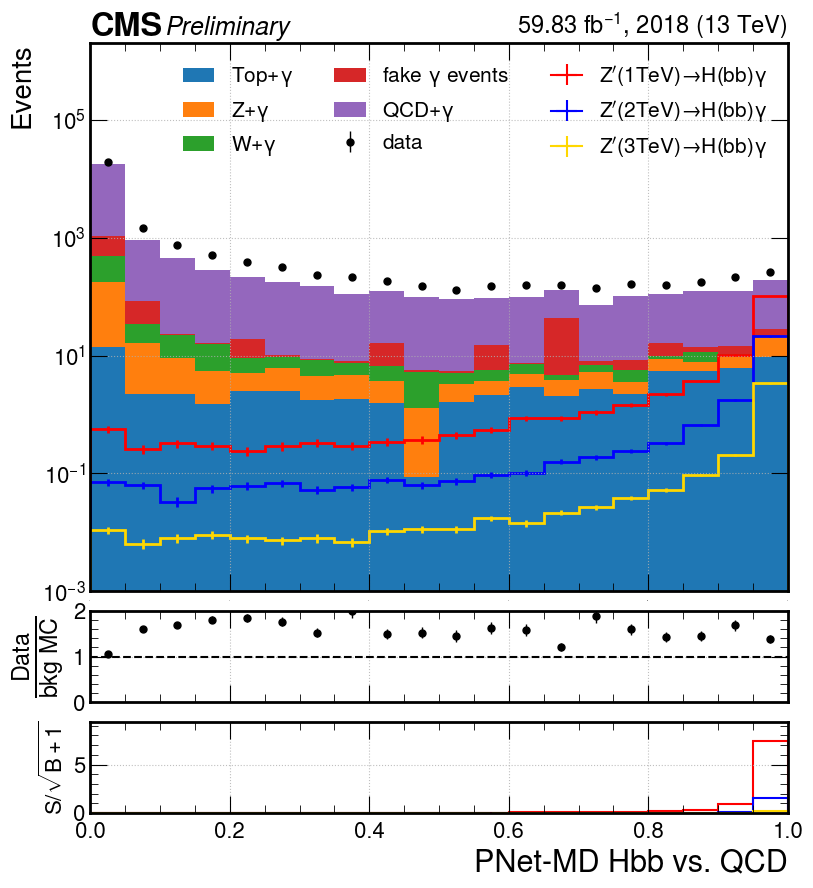

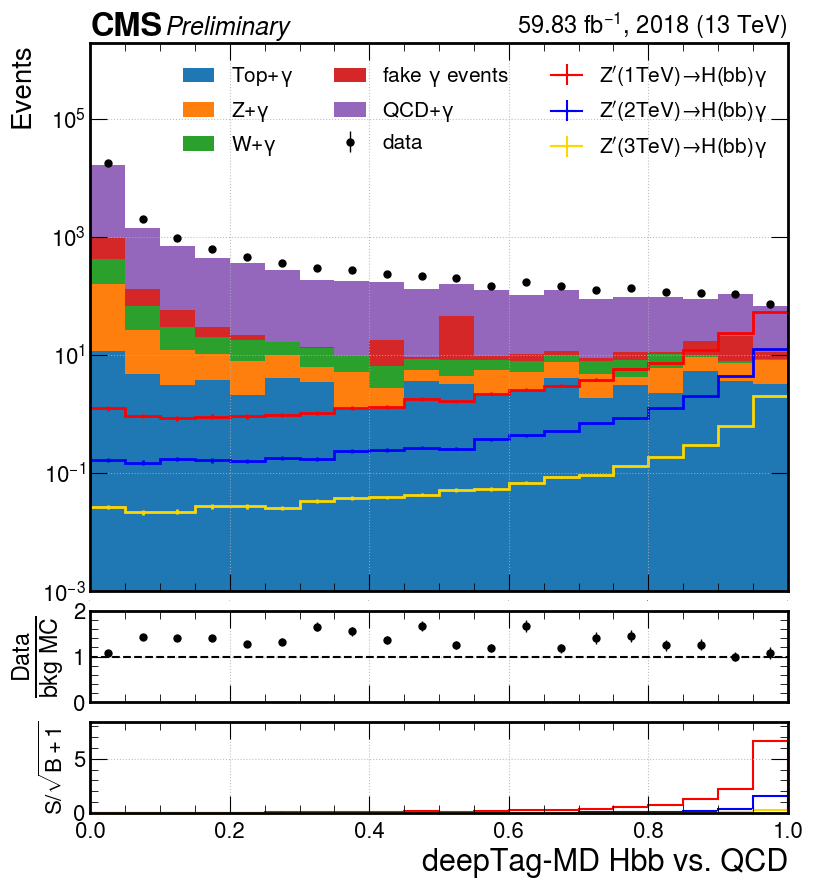

/tmp/ipykernel_2865453/710327429.py:59: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)


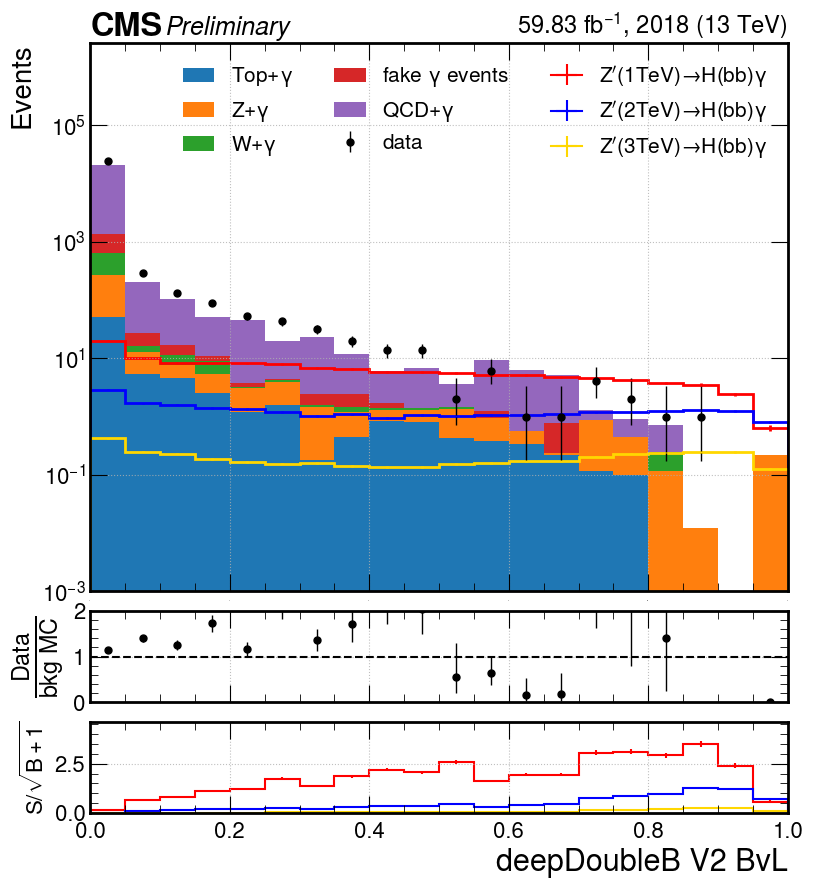

In [38]:
y='2018'
arrays={
    k: getattr(events[y][k], 'AK8jet_inclParTMDV1_probHbb')[
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'ParT-MD Hbb vs. QCD', plot_name='AK8jet_Hbb_tagger', x_max=1, bins=20, weight=_weight, year=y, fraction_log=False)

arrays={
    k: getattr(events[y][k], 'AK8jet_btagHbb')[
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'double-b tagger score', plot_name='AK8jet_doubleb_tagger', x_max=1, bins=20, weight=_weight, year=y, fraction_log=False)


arrays={
    k: events[y][k]['AK8jet_particleNet_HbbvsQCD'][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'PNet Hbb vs. QCD', plot_name='AK8jet_ParticleNet', x_max=1, bins=20, weight=_weight, year=y, fraction_log=False)

arrays={
    k: (events[y][k]['AK8jet_particleNetMD_Xbb']/(events[y][k]['AK8jet_particleNetMD_Xbb']+events[y][k]['AK8jet_particleNetMD_QCD']))[
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'PNet-MD Hbb vs. QCD', plot_name='AK8jet_ParticleNet-MD', x_max=1, bins=20, weight=_weight, year=y, fraction_log=False)

arrays={
    k: events[y][k]['AK8jet_deepTagMD_HbbvsQCD'][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'deepTag-MD Hbb vs. QCD', plot_name='AK8jet_deepTag-MD', x_max=1, bins=20, weight=_weight, year=y, fraction_log=False)

arrays={
    k: events[y][k]['AK8jet_btagDDBvLV2'][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'deepDoubleB V2 BvL', plot_name='AK8jet_deepDoubleB', x_max=1, bins=20, weight=_weight, year=y, fraction_log=False)


In [21]:
def tagger_study_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, fraction_log=False):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    #ax = plt.gca()
    plt.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
    
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        if 'delta_phi' in plot_name:
            values = np.min([v, 2*np.pi-v], axis=0)
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var
        
    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=density, stack=True, linewidth=2, ax=ax)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        # we usually don't care error of background MC cuz the stats is very large (relative error is very small compared with signal and data)
    
    combined_significance = {}
    stats_data = {}
    for (k,h) in individual['h'].items():
        if k=='data':
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
        elif k in SIG_COLOR:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(individual['h']['data'])
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(individual['h']['data']), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            combined_significance[k] = {
                hist.axes[0].edges[i]: np.sqrt(
                    np.sum(h[:i])**2 / (np.sum(individual['h']['data'][:i])+1e-6) + 
                    np.sum(h[i:])**2 / np.sum(individual['h']['data'][i:])
                ) for i in range(len(h))
            }
            stats_data[k] = {
                np.sum(hist.axes[0].edges[i]): np.sum(individual['h']['data'][i:]) for i in range(len(h))
            }


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-3 if not density else 0, ax.get_ylim()[1]*(1e2 if not density else 1.2))
    if not density:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    
    #ax2.set_yscale('log')
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$\frac{signal}{\sqrt{data}}$', ha='center', fontsize=22)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots/tagger'):
        os.makedirs('./plots/tagger')
    plt.savefig(f"./plots/tagger/{year}_{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()
    
    return combined_significance, stats_data

/tmp/ipykernel_2865453/1468643620.py:62: RuntimeWarning: divide by zero encountered in divide
  y = h / np.sqrt(individual['h']['data'])
/tmp/ipykernel_2865453/1468643620.py:63: RuntimeWarning: divide by zero encountered in divide
  hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(individual['h']['data']), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
/home/dfu/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3648: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_2865453/1468643620.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  np.sum(h[i:])**2 / np.sum(individual['h']['data'][i:])
/tmp/ipykernel_2865453/1468643620.py:62: RuntimeWarning: divide by zero encountered in divide
  y = h / np.sqrt(individual['h']['data'])
/tmp/ipykernel_2865453/1468643620.py:63: RuntimeWarning: divide by zero encountered in divide
  hep.histplo

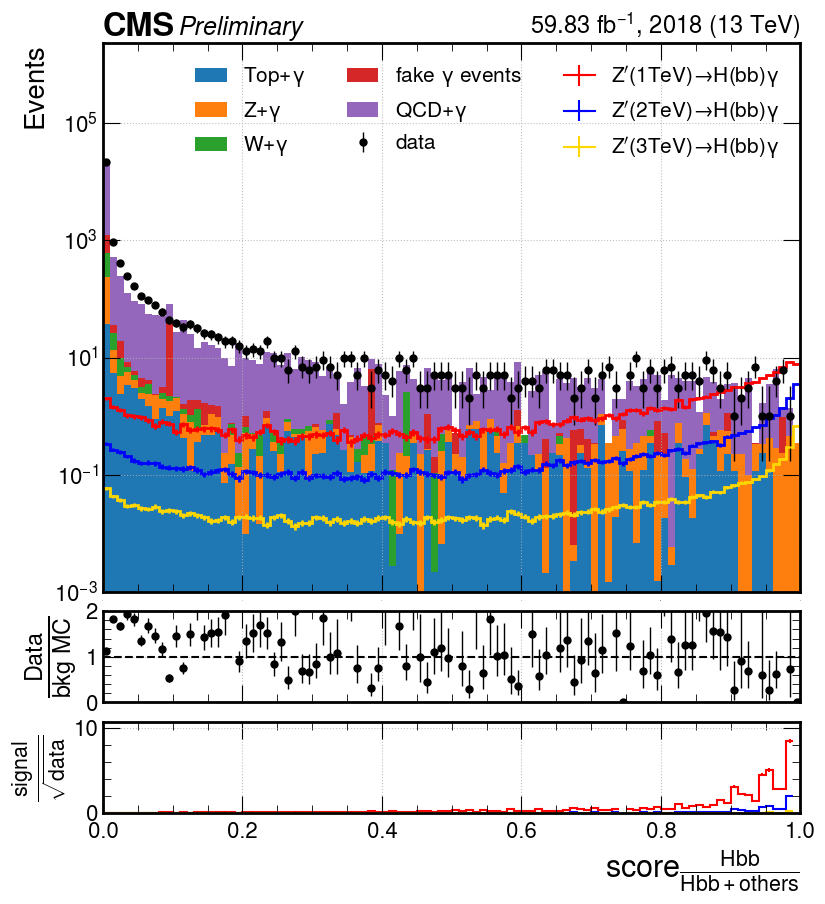

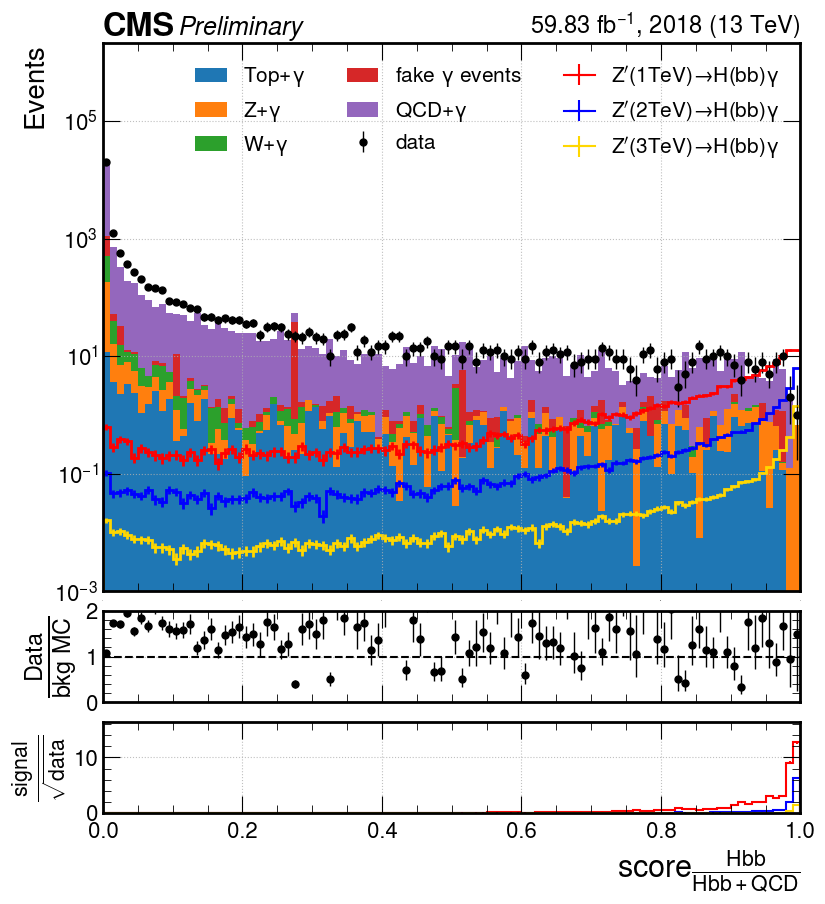

In [22]:
arrays={
    k: getattr(events[y][k], 'AK8jet_inclParTMDV1_probHbb')[
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}
CS_others, stats_others = tagger_study_plot(arrays, plot_name='score(Hbb vs others)', x_name=r'score$\frac{Hbb}{Hbb+others}$', x_max=1, x_min=0, bins=100, weight=_weight, year=y, density=False)

arrays={
    k: (getattr(events[y][k], 'AK8jet_inclParTMDV1_probHbb') / ak.sum([getattr(events[y][k], d) for d in ['AK8jet_inclParTMDV1_probHbb']+score_QCD], axis=0))[
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}
CS_QCD, stats_QCD = tagger_study_plot(arrays, plot_name='score(Hbb vs QCD)', x_name=r'score$\frac{Hbb}{Hbb+QCD}$', x_max=1, x_min=0, bins=100, weight=_weight, year=y, density=False)

In [25]:
a=zip(CS_QCD['$Z^\\mathrm{\\prime}(1TeV)\\to H(bb)\\gamma$'].keys(), CS_QCD['$Z^\\mathrm{\\prime}(1TeV)\\to H(bb)\\gamma$'].values())

In [26]:
for x, cs in sorted(a, key=lambda x: x[1], reverse=True):
    print(x, round(cs, 3), stats_QCD['$Z^\\mathrm{\\prime}(1TeV)\\to H(bb)\\gamma$'][x])

0.98 14.663 3.0
0.99 12.624 1.0
0.95 9.815 26.0
0.97 9.811 13.0
0.91 9.606 52.0
0.93 9.603 40.0
0.94 9.593 34.0
0.9 9.526 59.0
0.96 9.426 21.0
0.92 9.404 48.0
0.89 9.183 69.0
0.88 8.816 81.0
0.87 8.566 91.0
0.86 8.393 100.0
0.85 8.025 115.0
0.82 7.979 131.0
0.84 7.936 123.0
0.83 7.929 128.0
0.81 7.862 140.0
0.8 7.763 148.0
0.79 7.727 154.0
0.78 7.524 167.0
0.77 7.378 178.0
0.76 7.374 182.0
0.75 7.322 188.0
0.74 7.227 197.0
0.73 7.144 206.0
0.72 7.007 218.0
0.71 6.861 232.0
0.7 6.792 240.0
0.69 6.717 249.0
0.68 6.663 257.0
0.67 6.619 264.0
0.66 6.508 276.0
0.65 6.418 287.0
0.64 6.309 300.0
0.63 6.216 312.0
0.62 6.17 320.0
0.61 6.052 335.0
0.6 5.991 344.0
0.59 5.913 356.0
0.58 5.861 365.0
0.57 5.806 375.0
0.56 5.731 388.0
0.55 5.669 400.0
0.54 5.598 413.0
0.53 5.559 421.0
0.52 5.476 436.0
0.51 5.436 445.0
0.5 5.36 460.0
0.49 5.29 475.0
0.48 5.253 484.0
0.47 5.211 494.0
0.46 5.129 512.0
0.45 5.071 526.0
0.44 5.019 540.0
0.43 4.986 550.0
0.42 4.899 572.0
0.41 4.82 594.0
0.4 4.771 609.0
0.3

In [27]:
stats_QCD['$Z^\\mathrm{\\prime}(1TeV)\\to H(bb)\\gamma$'][0.9], stats_QCD['$Z^\\mathrm{\\prime}(1TeV)\\to H(bb)\\gamma$'][0.98]

(59.0, 3.0)

In [28]:
stats_others['$Z^\\mathrm{\\prime}(1TeV)\\to H(bb)\\gamma$'][0.9]

26.0

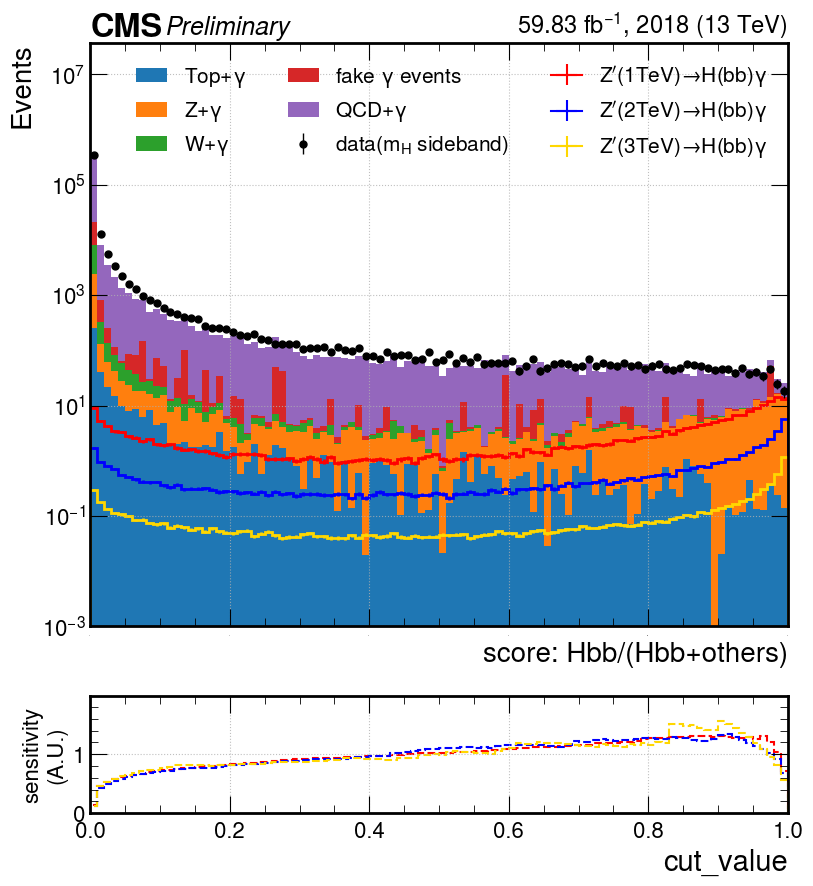

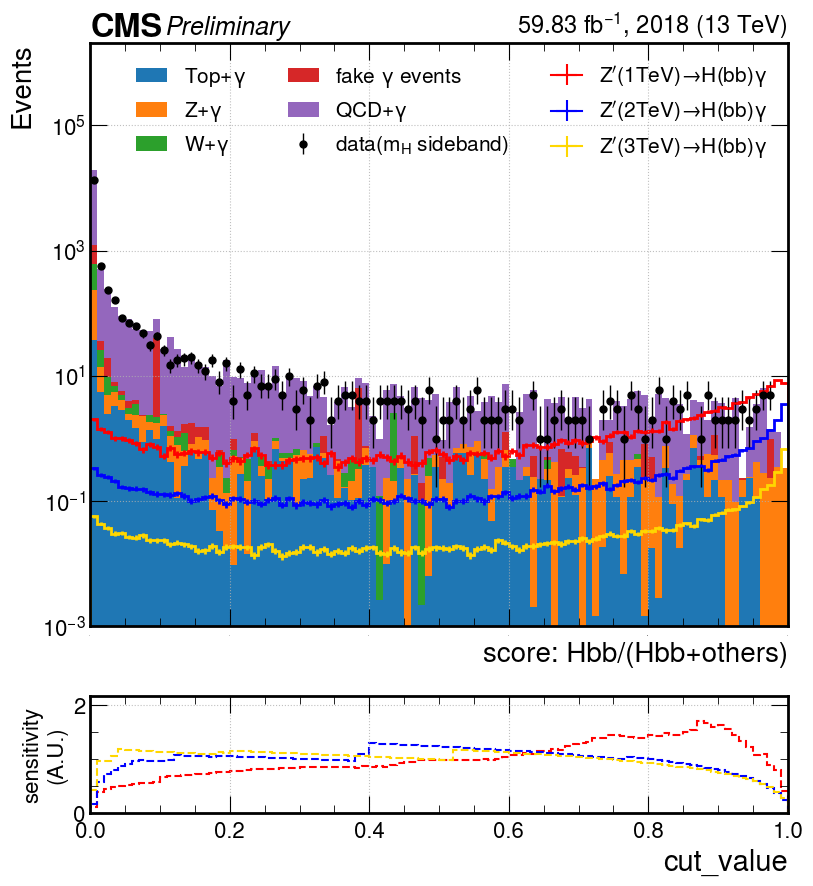

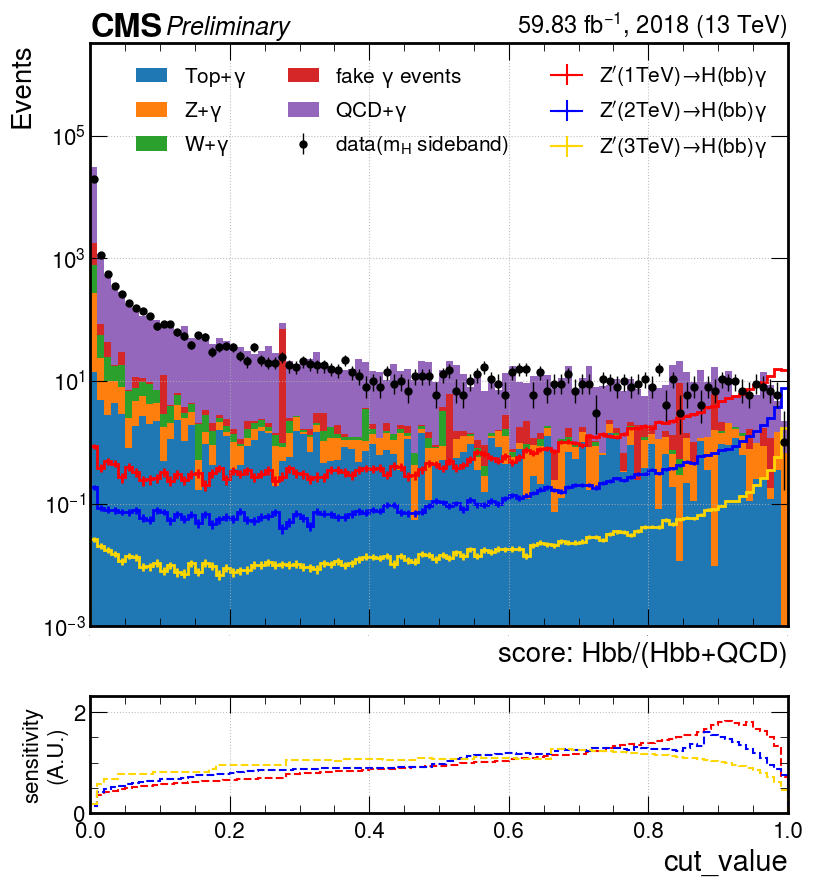

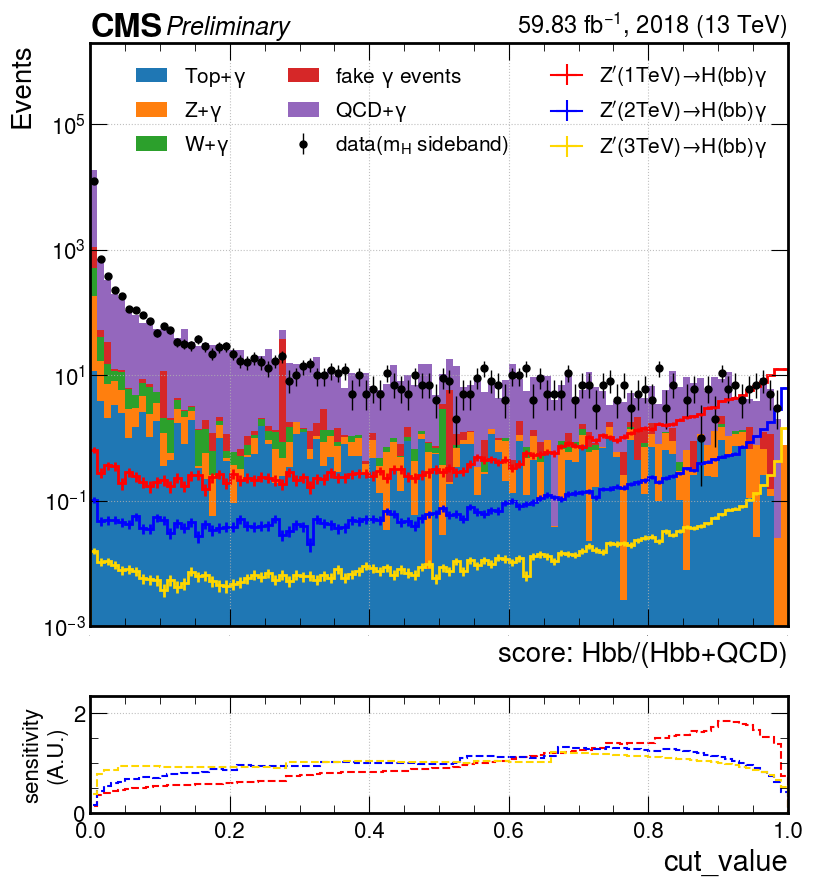

In [29]:
arrays={k: events[y][k].AK8jet_inclParTMDV1_probHbb for k in events[y]}
optimizing_plot(arrays, cuts=None, mode='greater', plot_name='pre_Hbb_score', x_name=r'score: Hbb/(Hbb+others)', x_max=1, x_min=0, bins=100, weight=weight[y], year=y)
optimizing_plot(arrays, cuts=eval(full_cuts), mode='greater', plot_name='Hbb_score', x_name=r'score: Hbb/(Hbb+others)', x_max=1, x_min=0, bins=100, weight=weight[y], year=y)

arrays={
    k: getattr(events[y][k], 'AK8jet_inclParTMDV1_probHbb') / ak.sum([getattr(events[y][k], d) for d in ['AK8jet_inclParTMDV1_probHbb']+score_QCD], axis=0)
    for k in events[y]
}
optimizing_plot(arrays, cuts={
    k: ((events[y][k]['AK8jet_msoftdrop'] > 100) & (events[y][k]['AK8jet_msoftdrop'] < 110) if k=='data' else (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140))
    for k in arrays
}, mode='greater', plot_name='pre_Hbb_vs_QCD_score', x_name=r'score: Hbb/(Hbb+QCD)', x_max=1, x_min=0, bins=100, weight=weight[y], year=y)
optimizing_plot(arrays, cuts=eval(full_cuts), mode='greater', plot_name='Hbb_vs_QCD_score', x_name=r'score: Hbb/(Hbb+QCD)', x_max=1, x_min=0, bins=100, weight=weight[y], year=y)